<a id="Top"></a>
---
---
                                   ___                                     ___           ___     
        _____                     /\__\                                   /\  \         /\__\    
       /::\  \       ___         /:/ _/_       ___           ___         /::\  \       /:/ _/_   
      /:/\:\  \     /\__\       /:/ /\  \     /\__\         /\__\       /:/\:\__\     /:/ /\__\  
     /:/  \:\__\   /:/__/      /:/ /::\  \   /:/__/        /:/  /      /:/ /:/  /    /:/ /:/ _/_ 
    /:/__/ \:|__| /::\  \     /:/__\/\:\__\ /::\  \       /:/__/      /:/_/:/__/___ /:/_/:/ /\__\
    \:\  \ /:/  / \/\:\  \__  \:\  \ /:/  / \/\:\  \__   /::\  \      \:\/:::::/  / \:\/:/ /:/  /
     \:\  /:/  /   ~~\:\/\__\  \:\  /:/  /   ~~\:\/\__\ /:/\:\  \      \::/~~/~~~~   \::/_/:/  / 
      \:\/:/  /       \::/  /   \:\/:/  /       \::/  / \/__\:\  \      \:\~~\        \:\/:/  /  
       \::/  /        /:/  /     \::/  /        /:/  /       \:\__\      \:\__\        \::/  /   
        \/__/         \/__/       \/__/         \/__/         \/__/       \/__/         \/__/    
---

#### December 2016


### Table of contents

* [Build prediction models with tflearn and tensorflow](#TF)
    * [Softmax regression model](#SR)
    * [Multilayer convolutional neural network](#CNN)
    * [Serialize trained CNN model for serving](#Serialize)

* [Classify digit examples from Digitre](#Digitre)

In [1]:
# Standard library
import datetime

# Third party libraries
from PIL import Image
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data

import prep_digit_image as prep

In [3]:
import imp
imp.reload(prep)

<module 'prep_digit_image' from '/Users/luis/Git/digitre/digitre/prep_digit_image.py'>

In [4]:
# Latest update
str(datetime.datetime.now())

'2016-12-18 17:10:03.023152'

In [5]:
def print_elapsed_time(t0):
    """
    Given a start time (time.time() object), computes and prints elapsed time.
    
    Keyword arguments
    ~~~~~~~~~~~~~~~~~
    :param t0: output of time.time()
            Start time to compute elapsed time from (no default)
    :return: Pandas data frame concatenating all read files
    """
    elapsed_time = time.time() - t0

    if elapsed_time < 60:
        print("{:2.1f} sec.".format(elapsed_time))
    elif 60 < elapsed_time < 3600:
        print("{:2.1f} min.".format(elapsed_time / 60))
    else:
        print("{:2.1f} hr.".format(elapsed_time / 3600))

<a id="TF"></a>
# Build prediction model with tflearn and tensorflow

<a id="CNN"></a>
## Multilayer convolutional neural netwrok

Code based on this tflearn [example](https://github.com/tflearn/tflearn/blob/master/examples/images/convnet_mnist.py), with CNN architecture modeled after TensorFlow's tutorial [Deep MNIST for experts](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/).

In [6]:
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [7]:
# Data loading and preprocessing
import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data(one_hot=True)
X = X.reshape([-1, 28, 28, 1])
testX = testX.reshape([-1, 28, 28, 1])

Extracting mnist/train-images-idx3-ubyte.gz


/Users/luis/miniconda3/lib/python3.5/gzip.py:274: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._buffer.read(size)
/Users/luis/miniconda3/lib/python3.5/site-packages/tflearn/datasets/mnist.py:52: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [54]:
### Building convolutional cnn
cnn = input_data(shape=[None, 28, 28, 1], name='input')
# 1st convolutional layer:
# Convolution computing 32 features for each 5x5 patch
# Stride of one and zero-padded convlutions (defaults)
cnn = conv_2d(cnn, 32, 5, activation='relu', regularizer="L2")
# Max pooling over 2x2 blocks
cnn = max_pool_2d(cnn, 2)
cnn = local_response_normalization(cnn)
# 2nd convolutional layer:
# Convolution computing 64 features for each 5x5 patch
cnn = conv_2d(cnn, 64, 5, activation='relu', regularizer="L2")
cnn = max_pool_2d(cnn, 2)
cnn = local_response_normalization(cnn)
# Fully connected layer
cnn = fully_connected(cnn, 1024, activation='relu')
cnn = dropout(cnn, 0.5)
cnn = fully_connected(cnn, 10, activation='softmax')
cnn = regression(cnn, optimizer='adam', learning_rate=0.01,
                 loss='categorical_crossentropy', name='target')

With latest stable TensorFlow version (0.12) throws "`ValueError: No variables to save`".

Needed to revert TF back to **version 0.11** for this to work:
```
$ pip uninstall protobuf
$ pip uninstall tensorflow

# Ubuntu/Linux 64-bit, CPU only, Python 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-0.11.0rc1-cp35-cp35m-linux_x86_64.whl
# Mac OS X, CPU only, Python 3.4 or 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.11.0rc1-py3-none-any.whl

$ pip install $TF_BINARY_URL
```

In [20]:
# Training
t0 = time.time()

model = tflearn.DNN(cnn, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y}, n_epoch=10,
           validation_set=({'input': testX}, {'target': testY}),
           snapshot_step=100, show_metric=True, run_id='convnet_mnist')

print('-----')
print('-----')
print('Completed in')
print_elapsed_time(t0)

Training Step: 17200  | total loss: 0.45195
| Adam | epoch: 020 | loss: 0.45195 - acc: 0.9702 | val_loss: 0.03177 - val_acc: 0.9892 -- iter: 55000/55000
Training Step: 17200  | total loss: 0.45195
| Adam | epoch: 020 | loss: 0.45195 - acc: 0.9702 | val_loss: 0.03177 - val_acc: 0.9892 -- iter: 55000/55000
--
-----
-----
Completed in
1.2 hr.


In [ ]:
# Visualization
# Used "tensorboard_verbose=0", meaning Loss & Metric
# Run "$ tensorboard --logdir='/tmp/tflearn_logs'"

In [44]:
# Save the model
model.save('mnist_cnn.tflearn')

<a id="Digitre"></a>
# Classify digit examples from Digitre

In [21]:
# Example digits collected from Digitre
b64_0 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAOZ0lEQVR4Xu2dSag1RxmG3+DKTVQURI04QSIEjLqISKLRTXSnQhAVJGZQcCGJoEhAHEAJOMWsBE2M4kIXigoK4sIxWegicUDQKGgwDrhRs3IjysvfpZX6+9yqrj733q7+nt78ybn11anv/eo5NVdfIh4UQIGDClyCNiiAAocVABBqBwqcoACAUD1QAECoAyjQpwAtSJ9uWAVRAECCBBo3+xQAkD7dsAqiAIAECTRu9ikAIH26YRVEAQAJEmjc7FMAQPp0wyqIAgASJNC42acAgPTphlUQBQAkSKBxs08BAOnTDasgCgBIkEDjZp8CANKnG1ZBFACQIIHGzT4FAKRPN6yCKAAgQQKNm30KAEifblgFUQBAggQaN/sUAJA+3bAKogCABAk0bvYpACB9umEVRAEACRJo3OxTAED6dMMqiAIAEiTQuNmnAID06YZVEAUAJEigcbNPAQDp0w2rIAoASJBA42afAgDSpxtWQRQAkCCBxs0+BQCkTzesgigAIEECjZt9CgBIn25YBVEAQIIEGjf7FACQPt2wCqIAgAQJNG72KQAgfbphFUQBAAkSaNzsUwBA+nTDKogCADJGoF8l6QdjFHVfpQSQ7cbzuZLukvRiSX+S9DtJb9tucfdZMgDZTlwNwgclvb5SpB9Kum5K4//+l6S/SPqwpD9sx519lARAthNHd6FSxT+pVD+XdFUGiP/Tdj+T9JLtuLOPkgDIduJoQJ4u6YVZkf4p6UmS/i3pCRkUeQvijw3Gg5JeKul7U2tiYHhWKgAgKwU8ovmvJV1xIL+yW5UAeUDSUyU9YwIpmfvzb0v6jKR/HLGM4bICkG2E3IPv+2aKcpOkL1SK6JYidbmc1HBcI8lQ+fPbJX1xG26OVwoAOf+YzcFxv6R7G+Bw6Z8s6dOSPBX86ATHY5L+k7UqzusjDOKXBxtAlmt2TIs1LcdcOQyJWxzPZqVu2MOSLp9aFEPj2S7WVBqjCCCNQp1CMsNxi6Rri7xbulUnFcctyjslvW9qQXJAEjS0KI0BBZBGoY6cLG853J1KkKyFIy+mFxrfP0Hoz9NAPwHjwfvHGMifHFkAOXLNb8hu7Zij4Ssel8Tdrg9Nn7gFSYAkaPwvXa8DqgLI0uq2Lv2xxxxLSlO2KGkg71kwul4AsqQunUraN0n68kzOx+xWtRTckHrWK4Ex1/V6AwP5C1LSgrRUqfVpvM/qIUn5eMO5njUcyRMP5N8i6R3TQmLZ9fJaiscv4We7AGR95a/l4K6N4XCl9JMgOS84yvKWXa+00OipYm9hCb0SDyC16r3+7+VKt3N8s6SvrM/6qDl4xf2GbKGRvV10sY5aweYyc6XzmY788UJdmlU69QIs/II7JF0/tRzeJJketyr3NK7sL/zKbSenBTm9+JRdK3/TNxvOe5xeidpyPrS3y5BcJun7kt4dpesFIG2VpieVV6tvzgy9dd3QbL1PP7e3K41Lkjthzp4ASE/Vr9t4cc6/tK5I1ti7arcyKK+X/v8pPCV86zQuSZ96/cTjkz9L+tzeZ7oAZEl1aU/rGaDnZMk/n235aM9lGyk9Re0x06snMDyz5fFJWpH3VLC7XLs8oAUgx6+Ec6vlrlR7qED5+ORHkl45yeduozdIbm1mbnV0AWS1hI/LwP13r3l4rJEeH1bay20k9s/b6V833bTyrMnJNEbZyw/B/4IHIMcFxF0R30ySHg/M3UXZ220jr5i6jDdmJxjts1uS5w0wEdEcdQBplqqa0L+uv89WzG2w5TWPqkMNCeb2l3n2zgP7XTwAcrwwpkU23yxyqaRRpnXXKpBaTQ/avW3eF0/s5ocBQNZWjwv2eethMDwO+a6kO4+T/eZz8Sq7T0fmzxa30ywWEkAWSzZr4IGr++P52GOERcHjeH/hB8LjrLQ9xYP2K6ep4aFn7wBkfRVJW9nznEZcFFyrRNIhX3UffkcwgKytFhfWN/J7qR4ppnnXf8M4OcwN2u+e7uYax4uspACyLmxzu3W94hz5oJFPK96Wyeqb6T0e+fE6qc/HGkD6dXe/2xdJ/1XS1VM2I+zW7fe43dJdq6dMW1PSu038wzHcAyD9IcsH5j+R9ExJL9rTIlm/NPJCos/fp5V2ZzXkuAxA+mrB3MDcG/bcveC5oMA3pi0pSY8ht8gDSF91Lt/lEXlgfkhBT3N7Z0H+eHPjUGMRAFkOyFzgow/MD6nobujLpzdgvUDS10ab0QKQ5YCUi4K+V8oDUZ6LFfDr5L6efTycVgCyrFrPbUj0JWvub/NcrID1+nvx8VB1bqjCbqAG+qK1t06zVd6QyNijHhSP17yJMT1DTfcCSD3AeYq0au4Nib+U9CVJn12WRbjUORx2fqg6N1Rhz7lqzQ3OfThob4ehji0zgBxb0Y3mV26hYNW8LVB0sdp0Gj5VeVPJkCvD5xAFWpBzEP2sv3Ju5dx7jbZ+CdxZ6zT3fQCyhSicchnKXbt0r9oFp4vVrtWwKcszH3Sv2kNJC9Ku1bApPa37i6n03rHrA1LMXtXDma5gTSl9PMDd1WEepnnroRo+yHUXTy1FecskW01OTerzy7i8DG5PNyWetqq+CumN02TGEyV9VdInTvtLj5k/LUhdzfJcA+c+6pqlFOWxgOH2rQFIPdhlkNnaXtcspfA0eP6mquHu7gWQerABpK7RXIq5rTnD1bfhCtwXq1VWQ09TrvJ8nXE5uTHcAN3uA0i9EgBIXaO5FO+R9HZJl09/HHJyA0DqwQeQukZzKfLJjd9I+tSIRwMApB58AKlrNJei3Nw55OQGgNSDDyB1jcoUwx+1TQ4BSD34AFLXqExRrqAPt8UEQNqDDiDtWqWU5c0vw75QhxakHnwAqWtUpvDLg/wa7DSDNdwCIS1Ie9ABpF0rp8y7V49K+pWk1y7LYjupaUHqsQCQukZ5ivLszLDdKzsFIPXgA0hdo5SiXD3350Pf/AIg9eAPfWS07t5RU5RrH8MfTQaQev2gBalr5BRzb9sadnDOIL0t6E4FIHWtvHPXmxHzt20NufeqdJUWpB58AKlrlB8J2NXbtgCkHnwAOVmjua7Vbk5dAgiA1BU4nMJdq4ckee9VeoY893HIRQCpV49yXn/IXal1N7tSlKctfT2Sr/XZzZVIAFKvFxy5nddo110rZrHqYKQUAHKxVnOzVrvqWgEIgLQrcHHKuVkrv8F2N10rAGmvHuV7QYbeW9Tu9sGUIbpWANJeU8qbFd872u2A7a5WU+5+1qpUgEF6tU7It3N8PEsWuQXZ/awVgNSBKFMM/67v5S7PWoTqWtHFaq81u7gArd3d2ZThulYA0l5jdnNDR7vLF6W8R9It2ae7WxA8pA1jkLZaE3k/Vpqk8OVvri8+Z76bvVa18ANITaELf4+63WTuhOC9km5tk238VADSFsPyGpsIv6DuWnojoscf6XHXyv8f5u2+ANIGSMS33JYvDrJS4TZqAkgbIPl70h+etlS8ps10yFRli2kn7p6O1Q7pUG+hAaRdue9IulLSZZPJcK8Ta3S13Dlgs2GvDm30+WAyAGlXsNyTNfyNHTOul3fqOskj0xmPMOOOXBcAaQck72Ylq6HvfCpcNxxe67i2GJR7JsuzeCEfAFkW9l3dGpi5nrcc90+QeMYqNBzWB0CWAVJ2QdztcCsycvdjrltlSD4pyTNZoR8AWR7+dHvgY5IelOSbzO9cns0mLObgcMFukuSZrPAPgCyvAndIul6Sbw1M7wAfcSwCHA2xB5AGkYokXmH2WMTvv0iPz0l4EW2UBzgaIwUgjUIVycozIv7zKAtpwLEg5gCyQKwiaXm6boS++9xU7gjl7o/SSksA6RfQXS0P2NM4xDk9IMlnJ7Y4wJ2bygWOSvwBpB8QW3rx0C2JITEc10zZbW0WqNwF4GJ6Ktdb17cI87qoHNEaQNaL6fGIL3ZIcKQcvQPY45LzfNzK3SfJZcwfLwK6fMBBC3Im9fPQwNcV0K3JeTxu3QyH/y3hCL9C3hoQWpBWperp/CttIPIxia28Gm1IznK13Ttyb5b0bOCoB+6kFACyTr/SOh+TpL/5/MjfJL3rDDb9GdK7plN/fpHNy7ICesu6/76760GPG8LH5wYgx1fXkLjV8EKit6P4wge3Km5B/Mt+7HGJj8DeOL2fPD8ea89+KulqSX4dmsccZ9mKHV/Zc8gRQE5HdA+OvyXpaZKuKL7Cv+AflfTb6b1+S0pgAAye//U4wjA+X9KlBzL5o6QPMBhfIjEtSL9ayywNiVuM22bM3N25avrcrw24LktT/n/tW/Pp5TytWyp/P61GTcET/k4LskK8RtNDg/dkfkxAPH3r7p3BYKzRGCAG6UcQamUW7hJ5DODpYFfc1Ho427WAGApvnvQMmuGgxVgZrNycFuSIYjZk5W7XDdOJPY8fDMoSQHw+3IAZAkPhVXz/CxQN4vckAZAe1bAJowCAhAk1jvYoACA9qmETRgEACRNqHO1RAEB6VMMmjAIAEibUONqjAID0qIZNGAUAJEyocbRHAQDpUQ2bMAoASJhQ42iPAgDSoxo2YRQAkDChxtEeBQCkRzVswigAIGFCjaM9CgBIj2rYhFEAQMKEGkd7FACQHtWwCaMAgIQJNY72KAAgPaphE0YBAAkTahztUQBAelTDJowCABIm1DjaowCA9KiGTRgFACRMqHG0RwEA6VENmzAKAEiYUONojwIA0qMaNmEUAJAwocbRHgUApEc1bMIoACBhQo2jPQoASI9q2IRRAEDChBpHexQAkB7VsAmjAICECTWO9igAID2qYRNGAQAJE2oc7VEAQHpUwyaMAgASJtQ42qMAgPSohk0YBQAkTKhxtEcBAOlRDZswCgBImFDjaI8CANKjGjZhFACQMKHG0R4FAKRHNWzCKAAgYUKNoz0KAEiPatiEUQBAwoQaR3sUAJAe1bAJo8B/AdhSHufd5bK6AAAAAElFTkSuQmCC"
b64_1 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAALC0lEQVR4Xu2dve9tRRWG3/sPgDQmVCAF2Kk0Fppc7SgIH0FrNMTGBky0NGpCYgHhoyUhQA9RwMSEkCAEQ6jEggIToyQ22nhvbYxmcfchw3AOZ/asNbP3mXl2Qzi/WWtmnve8d/aemTP7irggAIGTBK7ABgIQOE0Ag/DtgMAXEMAgfD0ggEH4DkCgjgAjSB03oiYhgEEmEZpu1hHAIHXciJqEAAaZRGi6WUcAg9RxI2oSAhhkEqHpZh0BDFLHjahJCGCQSYSmm3UEMEgdN6ImIYBBJhGabtYRwCB13IiahAAGmURoullHAIPUcSNqEgIYZBKh6WYdAQxSx42oSQhgkEmEppt1BDBIHTeiJiGAQSYRmm7WEcAgddyImoQABplEaLpZRwCD1HEjahICGGQSoelmHQEMUseNqEkIYJBJhKabdQQwSB03oiYhgEEmEZpu1hHAIHXciJqEAAaZRGi6WUcAg9RxI2oSAhhkEqHpZh0BDFLHjahJCGCQSYSmm3UEMEgdN6ImIYBBJhGabtYRwCB13IiahAAGmURoullHAIPUcSNqEgIYZBKh6WYdAQxSx42oSQhgkEmEppt1BDBIHTeiJiGAQSYRmm7WEcAgddyImoQABplEaLpZRwCD1HEjahICGGQSoelmHQEMUsdtj1HfkfQLSabp/yT9RNIHe2zoJbUJg1ySWqfb+pikhyR9W9Lbkq5KelXSA2N0b7teYJDt2EfU/CVJT0p6ZEn2rqT/Lgaxj9DXSRmAToAbhn9d0guS7L9/kXTnkbagr1MgADoBbhR+u6Q/SbIRxK6PJN2FQeLVwCDxTFtnNFO8tYwcaV3PS/qqpP8kH363dWNGz49BLk/hFyU9KOmmpOkvSfrBMnuV9gh9nfoC0Amwc7iZ4+Hllsq0s+eOgznsWcRuuw7Xn4+MMp2be/nVYZDL0dBGCHsoP1zXJb0p6XvLB7YOYrdeh8ume+0zLgcBDOKA1zE0Hx2s6o+XEeLa0o6fSvpRMpv1rCRbH+FyEMAgDnidQvMZK6vWRg8bHdKV8sPtl/3dZrWekvRcpzYOWw0G2be0NmP1O0nfypr5Q0lmiPT6Q7JAaJ/bDJZ9xuUggEEc8DqE/naZur01mbX6laRfHqnb9l+l1y2SDrdfHZo6ZhUYZL+6PiPp0aV5dkv1T0nvLdO5eavtNuxvyYdW/rCIuN8eXkDLMMg+RcpnrKyVf5R074lRwTYl/ibpCjNYQbpikCCQgWmOzVjZiGCjxKlbJrvlsq3uh4sZrCBBMEgQyKA0Zg5by0hvj47NWOXV2bPK/cmHxx7ig5o4VxoMsh+9T+2xKvmy/13SbUlXmMEK0hWDBIEMSPPaMk2b7rGyXwXaw/q5y9ZDDrdfN0v6xrkA/l5GAIOUcWpd6ov2WJ2rO99iYivs9rzCFUAAgwRAdKbIH7DtmeMdSfcV5mUGqxBUTTEMUkMtLubYdK7twrVRoXSRLzfYqYXEuFZPlAmDbCf2qencfI/VuRbmM1ilzy3n8vJ3ftS/2Xfg2HSuNcYertce1cMerIYyMoI0hHsitWc691hK9mA11BCDNIR7IvWx6VzPc0NuEDQN1BSYgTALUnmmc4+lz59jmOItEGFNEQyyhpavrP267+kkxdrp3GO18zNbnyZnozHIWUQhBfK1Cku6djr3WENYAwmR53QSDNIY8LKqnR7yZjWWbEAsaZn9Dv2JpKDnWaakvunKYJC2ktuMlU3Dfi2rJmozYb5I+LPlrN62vZooOwZpK7ZtNLST1u9IfjIbuZCXr4HYgXK2cMgVRACDBIE8kiadYbJbKtuSbouAtr0k6mKRMIrkiTwYpB3g/Mubn2MVUbPt17Lt7YfrK4sRI3KTg60mzb4D+fSrVRT13JE2mkXCZhLeSMwI0gbwy8sbnw7ZD+fnRtZmEwD/zhKiZyRhDBJM80a6wxE87y/Zv9lo9GCRsIl8n03KvzjxkNMjQC37K8kB05G15SvzLUapyPZeZC4MEiub3fbYAW7pqSQlhy7UtIIfStVQWxmDQVYCO1P8x5K+L+nuZd2j5eZB1kBitTuaDYPEQj58aW3dw7aXvCHp17FVfJotP+qn5sdWjZo2TloMEqtlzx8vcdRPrHaMIB14WhXprU+rf4A46qeTmK0E7NT8XVZzMMirkmw7eosrPw2Fw6pbUGYdpAnVw0trbBp27QEMpQ1iBquUlLMcI4gT4EbhHFbdCTwG6QQ6uBobmdLfmLTY5xXc5MtMh0EuUzc2KXbSDYN0Ah1YDZsUA2GeS4VBzhHa39/ZpNhREwzSEXZQVZxkEgSyJA0GKaG0rzJ2ksnPC14Lva9WX2hrMMjlCZe/HvpxTjJpJyIGace2VWYOamhF9kheDNIRdlBVrIEEgSxJg0FKKO2rDGsgHfXAIB1hB1TFGkgAxDUpMMgaWtuXZQ2kswYYpDNwZ3X5Lt5nJdmuYa5GBDBII7CN0vLCzkZgT6XFIJ2BO6tjBssJcG04BllLbNvyH0n619KEL0u6a9vmjF87BrkcjfMHdHtDlZ0gz9WQAAZpCDc4df479Ja/eQ9u+uWmwyCXox2/Q99AKwyyAfTKKjlJsRKcJwyDeOj1jWWTYl/en9SGQTaAXlllftQob5OqBLkmDIOsobVtWTYpbsAfg2wAvbJKu8VKTWJH/XA1JoBBGgMOTM8IEgizNBUGKSW1bbn0ldLWEs7i7aQHBukE2lkN29ydAGvDMUgtub5xvI+wL+9Pa8MgG4FfWS2HVa8EFlUcg0SRbJvHXuV2m6Q7l2p43Vpb3owgnfhGVJM+oP9D0oeS7olITI7zBBhBzjPaukS+SZH3oXdUBIN0hF1ZVb4Hq9V71yubN3YYBtm/vuzB2lAjDLIh/MKq2WJSCKpFMQzSgmpsTraYxPJclQ2DrMK1SWEMsgn2G5VikA3hF1bNLVYhqBbFMEgLqrE5GUFiea7KhkFW4dqkMCPIJti5xdoQ+6qqMcgqXLGFGUFiebbIxi1WC6qFOTFIIagNi2GQDeFjkA3hF1bNLVYhqBbFMEgLqrE5GUFiea7KhkFW4epa2F639pak65KuLjV/LOn2rq2YvDIMst8vwIuSHl4MYjrdJIk3SnXWC4N0Br6iunQXr51iYtcDkq6tyEFRJwEM4gTYMJxnj4ZwS1NjkFJS/csxe9Wf+edqxCA7EOFEExhBdqANBtmBCBhkvyJgkP1qwwiyA20wyA5EYATZrwgYZJ/a3Cvp9aRpvNF2I50wyEbgz1T7jKSHJP1V0q2Sfi/Jzufl6kwAg3QGXlhdftTPg5LsfF6uzgQwSGfghdXZaYrplf9/YRqKeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocmgEGGlpfOeQlgEC9B4ocm8H+eiCnYUGDMWQAAAABJRU5ErkJggg=="
b64_2 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAMqklEQVR4Xu2dTcgvZRmHf1KbKLSgTVlYiz4WgSVRgYa1qFVkkIEJUZGb2piBQYsyl608ERSBYbVRKKlW0RcaeRbZwoIWaQuLEmplRS3D+MU8vnPG+f/fmXtmnv/c73MNyOt5zzxf1z3XeT5m5pmrxAEBCBwkcBVsIACBwwQQhKsDAkcIIAiXBwQQhGsAAjEC9CAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACCNBJomhkjgCAxbqRqhACC7DPQb5X0cUn++TpJf5Z0c6+qv+z9ufy/fz4r6V5Jv91ns/LVCkH2E7OXS7pd0t2dFP2a9YXw7w8JYon+IenTkh7aT9Py1gRBTh87i3GnpM9K+t2gpyi1myPIZUk3SnobPcny4CLIcobRHPpi+P99/FOSY3L1INOpgry4k8PJ3ZO8vvsZrWPz6RCk/iVgGTwE+rykIsbYcOo7kn4o6U8Te4LbJD04aM63JN1Rv4kXp0QEqRdLT7Y9lPrEkaGUe5CvSPpG8F/+L0u6R9JTkp6T9CZJd0m6VK+ZF6skBNk+nh/qVqT8sxzDoZT/7IvY/3lotOS4X9Knehk4P89H3BNxzCSAIDOBTTzdvYWXaT1Zft+BNJ5XeBl3LTFKMS7by7zX9MplqDUxcMPTECQI7kAyzynu64ZRPuXJbpgzPN33Nb65YCh1Xq29IuZ69Ida75X06HkJ+fsrCSDIelfEeyT9YGTi/Yyka7tivIzrHuPb6xV7MKfhUMtDLK9qccwggCAzYB051RNvj/tvGjnnJ5L+0ElR8w63h29PDOpDLzIz3ggyE9jI6Zbjge73j/UkqdlbHGqFeyrPhcrxsKRblze5nRwQZFmsx+49WJJfSPKS66mP0os83i37vlPSK1ZYKTt1u6qVjyBx1L74HpH0+8HQ6pOV5hhTa/7TwUra3uo3tR0nOQ9B4th9l/uWwdBqjxdfuXlYWuo79B4WckwggCATIB04xUumvltdDi/b7vEJWq+uuacrh++/+HccEwggyARIyU/xjcOne21guXdGQBFkBqzEp/Z7OjeDuE8MJqAmgkp+GoIEA4ggQXDJkiFIMGAIEgSXLBmCBAOGIEFwyZIhSDBgCBIElywZggQDhiBBcMmSIUgwYAgSBJcsGYIEA4YgQXDJkiFIMGAIEgSXLBmCBAOGIEFwyZIhSDBgCBIElywZggQDhiBBcImS8TTvgmAhyAJ4SZJ6Py5vJlEOHnefETgEmQEr6an9F7vcBH8eYQ+vA6fAiSApwhSupPfp8jdD+ge7vs/AiSAzYCU89QuS3i/phm7HeO+04nfpOSYSQJCJoBKe5t7DbxL6p/f+9R5Z35P09YRtOVmVEeRk6DcvuGw/WgqyJH79dunm2JtXfE8FIMieorFuXfzu+XW9LJmcB/giSABagiT93R5dXXqPYNAQJAhu58m+L+nDvTqyF1YwYAgSBLfjZGWbn193dfR2o97VnQ/oBIKGIAFoO08ynJz/rFvq3Xm191k9BNlnXJbUyp9YuL6XwR63Q13SvqppEaQq7s0LG7tzzm7uC7AjyAJ4O0w6fDCRO+cLg4QgCwHuLLk/H/2u7mbgSyT50wdf2lkdU1UHQVKF62hl+4+WlBN5MHFhfBFkIcAdJR9+B8Rf0vWSL8cCAgiyAN6Oko59sPOu7ou6O6pmvqogSL6YDWvsodWvJL2l9xfuPSwNDyYujC+CLAS4g+R+Y/DNkl7VvfPhKvG555UCgyArgTxRNv3PPPuBxL9L+rEk303nWIEAgqwA8URZDB8pcTUuS/oAQ6v1IoIg67GsmdPwcXaXzbxjgwggyAZQN85yTA4Pr7z/lZ/D4liRAIKsCLNCVrdJenBQDnJsCB5BNoS7ctal53hM0k29vLlbvjLofnYIsiHcFbMeDquKJDzKviLksawQZGPAK2Q/Nudwth+V9NAK+ZPFEQIIsu/L45Ac9ByV4oYglUAHikGOALS1kyDI2kTXyW9stco503Osw3dyLggyGVW1Ew+tViFHtRCcFYQgJ4B+pMhLku7s/T2rVSeOD4KcOABd8X5k/T5J7j2GB6tVJ4wRgpwQfle039t4YOSzBL5D7k0YHj19FdutAYKcNvZ+Ivdzkl47qAaPj5w2Ls+XjiCnCYTfFXev4QcMvUWotwcth7fq8VCLBw9PE5srSkWQ+kHw5gqeiHveUY7HJb1DkjeZdq/Cq7L14zJaIoLUC8S7JX33wE4jf+n2r/Ibghw7IoAg2wfDPcU9km6V9JqR4vxZZg+p2H19+1jMLgFBZiOblWC4QmUZbu5y8ETcYnjTBY6dEkCQ7QJjOR4ZzDUsxb8l/Zy5xnbg18wZQdakeZbXoWep/N74x7p9rLYpmVxXJYAgq+L8f2aHnqVihWp91pvniCDrIh5uxcOzVOvyrZ4bgqyHvL+JWz9XnqVaj3H1nBBkOXIv494/+Kqsc2WVajnbk+eAIMtCYDm8UuWvyHrbzzf2lnDZp2oZ212kRpB4GIocXs718WS3gfTTPEsVh7q3lAgSj8jwa7LO6WFJd/AsVRzq3lIiSCwiYxPyH3U9Bw8axpjuMhWCzA/L2G4jlsMvN3FcMAIIMi+gfo/Dz1P9rXs83an9/oYn5PQc81imOBtB5oXJr7+Whw39otOrJX2Ql5vmQcx0NoJMj9bY0IoPZU7nl/JMBJkWtrFvkHuo5aEVxwUmgCDTgjtctfJdct//4CWnafzSnoUg54fOr8r6ozXX9k69V5LfLee44AQQ5PwA+4agV6+e6IZUXrUqd8/PT80ZqQkgyPHwDR9f/6uk23nhKfU1P6vyCHIY19jE3C89jW0POgs6J+chgCCHYzU2MfdQixuCea7vxTVFkHGEYxNz7nksvtzyZYAg4zHz8q2HWEzM813Tq9YYQV6I08u33uitHEzMV73kcmWGIFfGy8u3Xxt8h/yr3R5WuSJLbVchgCBXYvQuh7dIKruR+I45E/NVLrWcmSDIlXHzCtU13a8syRf5gE3OC3utWiPIGUlPyp8dgIXPWlda0ny4AM4C9xlJH5F0g6SruxejeFo36YW9VrUR5Ixk2YThv5JeJOmPkt4wAN3fnX1ODLxs3H/yt/z5X52M5TuEnvPwZak5ZDc+F0HOAPsifa7b4+o6SZcl3biSIIfCeEy4IpHnRZam/HReTsdRgQCCnEH2BWkxykU7dvFGe5CIIOeF308VW+i+QEUqeqLz6E38ewQ5A+X5xqXugvN753sXZGKIn+99ikj/kfTSkdU5eqURoggy9TJbdp5vQPY/2ul7K/7PH9PxZ9nK+yX+nXuxvRxj/0j0h3p96X7TVfpCiYYge7kUX1iPIlWRqfwsol1foepTh5TPDN64LOJ47uS/szz+eFC6V5QRpMJVtmERZRm6/OxLtUZPNFWQY018qrepd7pXlRFkw6t3J1kXedwDvVLSy7p6De/xlP2++tWeIsiw9zjWbATZyUVBNbYjUIZ6LqFIV+ZRHv71h3793sPnI8h2cSHnRASKRG/vLUJ4+OdVwlS7wTDESnTVUdX6BBCkPnNKTEQAQRIFi6rWJ4Ag9ZlTYiICCJIoWFS1PgEEqc+cEhMRQJBEwaKq9QkgSH3mlJiIAIIkChZVrU8AQeozp8REBBAkUbCoan0CCFKfOSUmIoAgiYJFVesTQJD6zCkxEQEESRQsqlqfAILUZ06JiQggSKJgUdX6BBCkPnNKTEQAQRIFi6rWJ4Ag9ZlTYiICCJIoWFS1PgEEqc+cEhMRQJBEwaKq9QkgSH3mlJiIAIIkChZVrU8AQeozp8REBBAkUbCoan0CCFKfOSUmIoAgiYJFVesTQJD6zCkxEQEESRQsqlqfAILUZ06JiQggSKJgUdX6BBCkPnNKTEQAQRIFi6rWJ4Ag9ZlTYiICCJIoWFS1PgEEqc+cEhMRQJBEwaKq9QkgSH3mlJiIAIIkChZVrU8AQeozp8REBP4HlbiK2F1vBtYAAAAASUVORK5CYII="
b64_3 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAANh0lEQVR4Xu2dTch/RRmGb6FVRSYRFBUWkRItSggzNM1NUBTqRqKNii2KFmaLIIjUkBYRqIuCIlEXZdAihTZ9kGW6yEUfiwgtNOnDVWRWFLQo7pqj07y/j3Nm5vf1zDXwUv/XM3PmuZ+53pln5szMOSKhAAqsVeActEEBFFivAIDQOlBggwIAQvNAAQChDaBAnQL0IHW6kWsQBQBkEEdjZp0CAFKnG7kGUQBABnE0ZtYpACB1upFrEAUAZBBHY2adAgBSpxu5BlEAQAZxNGbWKQAgdbqRaxAFAGQQR2NmnQIAUqcbuQZRAEAGcTRm1ikAIHW6kWsQBQBkEEdjZp0CAFKnG7kGUQBABnE0ZtYpACB1upFrEAUAZBBHY2adAgBSpxu5BlEAQAZxNGbWKQAgdbqRaxAFAGQQR2NmnQIAUqcbuQZRAEAGcTRm1ikAIHW6kWsQBQBkEEdjZp0CAFKnG7kGUQBABnE0ZtYpACB1upFrEAUAZBBHY2adAgBSpxu5BlEAQAZxNGbWKQAgdbqRaxAFAGQQR2NmnQIAUqcbuQZRAECO19Evl/RWSa+X9EpJr5H0tlRd/84/c9J3JD0j6WZJz87JwDMvKAAgx9Ea3p1gMADTT16zRyVdWlnVH0m6QtLPJV0JJMtUBJBlevV42j2DG6yh8M+LJV2wpeCpkde8P897t6QP1xQyah4A2Y/nPRy6StL12TBpevOc3uFhSZdXVtWAvFrSvyVdKOk2SbdWljVcNgDZncvdU1wr6aMroJg7fHLjdtzwiKSXSvphyujfecg0J31V0o3FgzdIundO5tGfAZD+LcC9xS2Srpb0yxmxw+OS/pka/G8TBG78vQJqg+pyz81Mda9lcIBki/8BpB8gBuOeFFdMpf5FkjV+WfGaXyQQ3CP4pxcM66xx4O/3GJJpSOd3Omif2xP1U+qESgKQdmf5L/RNG8b1U4M0FP6L/UD6i97+5mUlOP5xgJ7PhhmSN+wB0GU1PaKnAaTNGf7L7F7DOnrNokxPS/qcpO8eCIqyPobE9c0TM1sb2gCA1APycUl3pOzlUMrB9Z2pt6h/w25yegbLMdIT2cwWQfsarQFkeSN0rPHpFTNDHsufJ8ngeBh1zKmc2WKoBSBd2uunJH1SkuMO/wXOF/juS3DsOuDuYYghN9AO2p+T9NM0q/W1HoVHKoMeZJ433aC+JclDKa+CO3l61gtv/p3H9sfea5SWGvb3SLoogfJgmpqep8ggTwHIPEe78XslvIw1HODefiQB+DxLXnjK0D+VZXKPYlhImQIAMq85eA3Bn2o4vSp9uuFY49QX2iabJhVoD0V7QJB5gORPOf5wOoVYY5t1Ofh+1guHJHoQ2kBSgB5kS1OgBxmbFQABkLEJ2GI9gAAIgGxQAEAABEAApL4NEIPUaxchJz0IPUiEdrwzGwAEQHbWuE694HIl3Z/mzz1K6NRtn11/hlizpQr3oE9UeSizyp/o+3ckFgppA+nL4+uyAyXuSr9DHAChDaTP3addkP5Q8Yvpk3fEAZDh20A5vLIg3pvu009IADJ8Gyh3FBJ/rGkSBOnjseK98j6FxRu+7H/vivRXvNOhdOMpssFiABmrOXCqyUJ/A8hCwU748Q9Kur+ov3dIeu0jwt6WnbgGQHYi69EVOh314zN+L0u1MxwO1jlZkSHW0TXYfVVo1XGoEyTXnOBBE/vS7fn30IPsXfK9vNDbgn2qvE91LJN7jo9I+sZeanLiLwGQE3dgUX0fheoZKgfjqy7dYVi10N8AslCwI3vcMYSnad+b4onpQAlXc9VxqL6SgYB8gRMBZIFYR/DodFOVG/r0YeF0gN2q6rkXcZ5TOA71COQ9WwUAOUq3PF+p6aZbD53el05CnFtjf77+eUlfp9eYKxmA1Cu1u5z+C+9T4t0r9Eh/kvSKFQWVt1ZN//67pF8niHyHCUOwTDx6kB5Nsq2M/BqFtpL+l7vlRtzp/f5o0QD5x5+guMwhE4Ac3u3HCEipik+AfzLB4nOKhwEGQA4PiIdY/oDQh2NvSpuC8Txfjx6krMeqq6rds/xY0g8if+gIIIcHZF81KLfT+t9/S9dLT//NkwH5bbhT3dbd5f6YpIvTPhIf5O072EMlAAnlzm7GGBRD4//1jzdTlTf1rop3DImvcwuTACSMK3dqiKebDcy0/nJ+eptnvaZtu9NNVd+U9KWd1maPhQPIHsUO9KoJmEvS18H/ym6qCnURD4AEarUHMsWweGYrP4QuzD0jAHKgVhXstWFPaASQYC31QOaEvakKQA7UooK9lh4kmEMxp68CANJXT0oLpgCABHMo5vRVgBikr56UFkwBepBgDsWcvgoASF89KS2YAgASzKGY01cBAOmrJ6UFUwBAgjkUc/oqACB99aS0YAoASDCHYk5fBQCkr56UFkwBAAnmUMzpqwCA9NWT0oIpACDBHIo5fRUAkL56UlowBQAkmEMxp68CANJXT0oLpgCABHMo5vRTwKea/Dkrzhf35Bf59HvTAUpiT/oBRA/2Sh8o91Bmk88GLo85PVmTAeRkXXc0FQeQo3EFFTlGBcrrG+5KV74dY10X14keZLFkZCgU+Gy6Gu4fkl4k6UFJX4iiEoBE8eTh7PCBDVdkr78mHUV6uBp1fDOAdBRz0KLKKd7zIt1zCCCDtupOZl8v6Z6sLF+H4PtEwiQACePKgxhSDq/uk2RowiQACePKvRvyLkn3S3pN9mbfROUbcsMkAAnjyr0bYhC8Yv6ztDAYrvewogCy93YV4oW3Srols+T3kj6Ubr0NYeBkBICEcudejHEQ7l4jT6EWB3PDAGQvbSrUS3wH4XRxpw3zx4m+6/3ZUFYmYwAkold3Z9Odkm4qig+1MFhKByC7a0zRSvZHiV+WdEFmWMjAnCFWtKa7e3s8W/VUmrXy2odheTotCoYcWhGk775RRXpDGXf43zdLMiyhE0Os0O7tYty9kq4rSrpNkqd6wycACe/iJgPLvR4uzJ+zX91U6gllBpATctaeq1p+iOjXDxF3EKTvuaWd4OsMx42SLsvq7vUOB+eOP4ZJ9CDDuHq2oflnJI8kSIaEw4oByOZ2481ADlI9YxN6OjNN4d6x4nN1Q3J30mE2ZVEeBJCznix3yPmJ6Ati/r7KG5/KzU7uORyo+4/EkAlAzrr9AUlXFb927+GtpBGTAfiEpNcVxg07rCJI39zMvWrsv5glJFcGWxhzb+EhlQPvn0h6RyaLt846UB8qIF/VLOhB1sNSLpB5g9BFQWKRcj+HVXhM0sVpOOleJXrMNWs0ACDrZcr3PTwn6UlJPlbTjedUk3sLxxr+PL1Mv5P0mZHjDXqQ5c3af2m9auwGdW7KfopDLQ8bDca6FXCvjhv8UPvJl7v7bA56kO3xiMfh52ePuRH5cIJTSYb8WklvXlFhB+KONTwxQVqhAIBsbxartph6XcSbh445ueF737h7vzIId729TdbwEGts8CKAzGvi+U46z/D8VdIHjrRxOc7w7FS5puF6e6ssM1TzfP7fpwBknlgew39b0kuyhndsvYh7DH+Wvu5ujl9J+soJ9HzzPLKnpwBkvtDl1OgxxCIG1+s1rtuqmanJOu/fcC/IcGq+v+lBFmpVXjXm7Jcf6CwoD5/cW3jI5Fm1dcmfyBgeZqcWOnt6nB5kmXBePHynpGckvVHSb7Y00GWlb37aPYR7C0/HTr3F45IuXJHN6zUGI/yW2J4CryoLQJYpXF435tw37HBxbYLC7123hvFEdtIIPcYyf259GkC2SnTmgfJE80clfU+Sx/k9kodPb5f0sZlXCfgCzYeJMXpIf7YMAFmuqxuwIfHKuuG4NBXhANh/wd1gPZU6d9zv8hxLTL2EY53pu6hNtfPqt4d8LPIt9+HsHAAyW6r/e9CN+fYMjuk/5g3bgLjxOh6Y7hF343+TpLekOGLpdckGz1D4hxmpOt8tygUgi+Q6A4kbav4ZimHI7+vL44Mps09Cf+2M106wTVAYtrm90ozieWSOAgAyR6X1z7hH8GyRF+k85JpWq6ccjg08Fbwk+fsoD+G8MPl9oFgiXf9nAaSfpp5luiT9TL3IH4obmKa35b83EP4g0lC4lxh+k1I/l7SXBCDtGq4r4f1pNiqPMxw3GIA/SvLwy/+fWGJ3PmguGUCaJaSAyAoASGTvYluzAgDSLCEFRFYAQCJ7F9uaFQCQZgkpILICABLZu9jWrACANEtIAZEVAJDI3sW2ZgUApFlCCoisAIBE9i62NSsAIM0SUkBkBQAksnexrVkBAGmWkAIiKwAgkb2Lbc0KAEizhBQQWQEAiexdbGtWAECaJaSAyAoASGTvYluzAgDSLCEFRFYAQCJ7F9uaFQCQZgkpILICABLZu9jWrACANEtIAZEVAJDI3sW2ZgUApFlCCoisAIBE9i62NSsAIM0SUkBkBQAksnexrVkBAGmWkAIiKwAgkb2Lbc0KAEizhBQQWQEAiexdbGtWAECaJaSAyAoASGTvYluzAgDSLCEFRFYAQCJ7F9uaFQCQZgkpILICABLZu9jWrACANEtIAZEVAJDI3sW2ZgUApFlCCoisAIBE9i62NSsAIM0SUkBkBQAksnexrVkBAGmWkAIiKwAgkb2Lbc0K/Adnuq3YFbsD9gAAAABJRU5ErkJggg=="
b64_4 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAMgUlEQVR4Xu2dz4s1RxWG34AL3RgDIkiEKIguFD9FxIVijBtdCFF0KyoEN4IacOEucS9oFtlIQMU/QIOCcRUVXQiCBnGhKFGIIG5iViIIyvvNrW96au6P7uozd6rrPA3DfJlUnXvrPfV0/Tp9+j5xoQAKHFTgPrRBARQ4rACA0DtQ4IgCAEL3QAEAoQ+gQJsCjCBtulEriQIAksTRNLNNAQBp041aSRQAkCSOppltCgBIm27USqIAgCRxNM1sUwBA2nSjVhIFACSJo2lmmwIA0qYbtZIoACBJHE0z2xQAkDbdqJVEAQBJ4mia2aYAgLTpRq0kCgBIEkfTzDYFAKRNN2olUQBAkjiaZrYpACBtulEriQIAksTRNLNNAQBp041aSRQAkCSOppltCgBIm27USqIAgCRxNM1sUwBA2nSjVhIFACSJo2lmmwIA0qYbtZIoACBJHE0z2xQAkDbdqJVEAQBJ4mia2aYAgLTpRq0kCgBIEkfTzDYFAKRNN2olUQBAkjiaZrYpACBtulEriQIAksTRNLNNAQBp041aSRQAkHhHf07SzyT9Nd40Fs+tAIDEKv5uSb/dmTQgz0r6SuxHYO2cCgBIrNqPSfqiJIPiy4B8IvYjsHZOBQAkVu0fSnp0Z/J3kp6W9EzsR2DtnAoASKza/5J0/8TkeyQZFK6NKgAgcY6brj9s9RVJr4szj6XbUABA4lT3YvybE3OsP+K0vTVLABIn/XT9YauPS/pWnHks3YYCABKnOuuPOC27sQQgMa5g/RGjY3dWACTGJZx/xOjYnRUAiXEJ5x8xOnZnBUBiXML6I0bH7qwAyHqXsP5Yr2G3FgBkvWuelPTExMz3JDmil2sABQBkvRMd2v7wxMznJX13vVks9KAAgKzzgkNJXq5MvIVnQdaJ2lNtAFnnDYey/2Bi4oVJqPs6y9TuQgEAWecGT6U+OzHxFA9IrRO0t9oAss4jfmrwoYmJT0rymQjXIAoASLsj2d5t124zNQGk3VWEt7drt5maANLuKrZ327XbTE0AaXMV27ttum2uFoC0ucwn5d9he7dNvC3VApA2b7G926bb5moBSJvLnpP0TkkP7qqTvaRNx+5rAchyF01Pz1+S9AdJH1tuhhpbUABAlnvJiRi+PKlG9O5yDTdTA0CWu4rT8+WabbYGgCxzXX167toPSPIThVwDKgAgy5xaT69IDrdMv82VBpBlLnOe3TuTKjwctUy/zZUGkPkue7OkF6viTK/m67fJkgAy3211cCIPR83XbrMlAWS+6+rpFbl352u32ZIAMs91BCfO02m4UgAyz6UEJ87TabhSADLPpbzaYJ5Ow5UCkNMuZXp1WqNhSwDIadcyvTqt0bAlAOS0a9m9Oq3RsCUA5Lhr9x0OkjlxWByuNwxAjjubw8FEMOxrKoAc7wBMrwAkuQKHm8/0iq4hRpDDnYDpFYAAyJE+wPQKQADkQB9gegUcdxVgirW/I3xB0mckvUvSayUR2p4UGADZ7/gyvXpF0u8lfV/St5P2kdTNBpDr7md6lRqJq40HkOudgcQMAHJPAQC53hnqvFckZkgMDIBcdT55rxLDQKjJaeeTVvS0RqlKMIJcdbczJN4/+RMv5UyFw/XGAsilJvU7z73F66cJuRIrACCXzq9fikPW9sRglKYDyGUnqKdXj0jyizq5EisAIBfOr587/5skHxhyJVcAQC46QJ3W5ylJDnfnSq4AgFwsxF+u+gHvHEwOBmuQyw5QPxg1+vTqf1Xf5yZ55GaAOFK2B6MAZMHomB2QfaElo6f18c7cFBLv1nEdUCA7IBkjdxlBFtwOsgOSLXL3w5Ken/SPn0vy37gYQa4pkDG0BEAW3goyjyAZQ0uelPTEpI9w3nMCmKyA7Dv7yBBawntOGEFmKZA1tKTe0s5wU5jVIQ4VyjqC/FLSByaifF2Spx+jX3+U9M9dI98g6e2jN3ht+zICUrKW/Hon3vsljX724abWC/TRIwbWsnG3fkZA6tCSX0n6YIiafRup280W7wx/ZQQk29lH6Qb1DlaWaeUMDA4XyQZI5qwlDjF5eNIVSGc0A51sgGQMLSndgB2sGUDURbIBkjlrCTFYAHJUgYyhJVNBAARAjiqQMbSkCFKvvUhpNBOWLFMsh5a8WOW5ynSKTJDiTCCyrkGyhpYUfwMIgBxVIHvWkvqQ8FlJXpNxnVAgyxSrXqBmy1rCIWHjrSADIPXuVcYYJAABkIMK1LtXGR8SqjXgFH0mMBlGkDr2KuMrDeowk0w7eDNR2F9sdEDY/7/wO4A0YjI6ILwx6qJj1KNotk2KRjzGfx6kDtDLOvcmzKQRkZFHkH3vO39AkgMWs10A0ujxkQF5TJJ//Eitr6yHY/syuIzs90YU8i3Sp6fnfv78md1PqIAbMEaYyQonjXwnyX56XroFgADINQXI4HEpCdkUAeSaAnWnyPzGWsJMAOSaAiQouJSk1iJjJEEzIiOuQfbt2mTd3uUUvRmNi4ojAlJH774gySEnWa86UUWGLJJhvh4REBalV7uHownKW3w9ujrMhGumAiMCwpz70vl1NAHJGmaCUYqNCEh9/pF5SsEZyEIg6uKjAcL5x1UP1+ux20hY7VHsIUnvk/QOSf5vrwn94Fr3r5wYDZA6OUHm8w+jcs4zEHd6g+Df/vF6Z/qCUL+bZPo+kk0kzx4NkPrR0scl+ZmQrFckIGUkcMcvAPi3/+61zZ2FIgPIQsEiipOg+aqKczYs3Mnv31UrHb9A4D+Xvx3zzy8kfWiGA/8k6W27cgAyQ7DoIgakPO9hp2ff0vyNpPdORH5O0qt305/XS3pTkAOOAeLRxX7xz0uS/J38hKN/ur9GmmLVC/QsB4Ru93Tu7043nfufoxNaa4867vQetQoA0xvWOb5H+GeMBEidXnS0B6TqRXCZ/4d3igMGy0jg/20Iym+P2AZhyGskQOoEDZuY4x7oVR4B3rp7E68XwTc1Ivxd0n8n053pHb9AsJnp0E0QOhIgcxakN6HhWpsGwDtAhsCjQoHB05alO0PHvst/JH1tcrcvAKz9/kPXHwmQOiiv19Q2hsDvCixAGJA1l0HyXb4shMuUx5/z/MTwbRwSrmlXF3VHAqTXzB0GoQCxdKo0HUXKGmC6CD42ChBmEoDYKID0tIPlO/ejuxFiKRDFpU6w7RHhx5L+vPv30nRFAAIg9xS4zR2s6ZTJndLbnUsvT38MhEcE/444I6jDbjIm7V7qh2vlRxlBvirp05L+LelVuxxY31itzn4DXjN4yuRAwNdI+ujCzymjQ4HhphbLkWEmC5s4TvFRALnpHSzDMF1Ylx7gk+FTp9EGwt+v/ESMDnN6IIDMUelEmVEAiU7OPJ02nXpVmc8SHpzo7MW0k9adG4ja1QACIHcViEitaRtl2uR1xJKtV8ch+ZHWAkQvp8r1wWn2yOYmXEYYQT4u6UeT1s+NwSq7TR4hliZ18KLaQHik6AWIugPwTpAmJK5WGgEQ3yk/Jekvkt4o6SeSvINTXx4lyvaryy1ZXJd1RJk6Ld1yDXDVYhMAsliy6xVGAOTYAt3TpQLFdJSYs7h2sGMZJc61sA5w6T0TABKg5giA1CfoX5L0kd1B3bEziXpx7alZAeKmtl4DXDbbBIDMlupwwREAcUcwJM5e4uci5gb5/VTSPzrYbQpw414TABKg7AiAlCBFL5y9E3XsMjxeR/S8uA5w610TdfBm5vSrzZqOAEhJ1DAFpIwi00M6Q7GFxXWzM6uKvQZvRrXvLHZGAMRnFt7J8nrD/y5Bfn72udct2HM4F0ACVB4BkAAZhjQBIAFuBZAAETs1ASABjgGQABE7NQEgAY4BkAAROzUBIAGOAZAAETs1ASABjgGQABE7NQEgAY4BkAAROzUBIAGOAZAAETs1ASABjgGQABE7NQEgAY4BkAAROzUBIAGOAZAAETs1ASABjgGQABE7NQEgAY4BkAAROzUBIAGOAZAAETs1ASABjgGQABE7NVGetCxf75FOv2fXXwtAunbPqi/HCLJKvovKABIgYqcmACTAMQASIGKnJgAkwDEAEiBipyYAJMAxABIgYqcmACTAMQASIGKnJgAkwDEAEiBipyYAJMAxABIgYqcmACTAMQASIGKnJgAkwDEAEiBipyYAJMAxABIgYqcm/MqGKSRO7s21UAEAWSjYhoo77eqd3ff1u05OvWtxQ00731cFkPNpfe5Pcp5iv2nLOYuduzhznuJm7QGkWToqZlAAQDJ4mTY2KwAgzdJRMYMCAJLBy7SxWYH/A1s9FOc0AL8jAAAAAElFTkSuQmCC"
b64_5 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAANd0lEQVR4Xu2dTch1VRmGbyGaFFpQkElYVDoo1BoYIfZDJURGRRLWxEIJGpX0DSoisyKhgSUNTFFSCpJIKmqSBfajSCGUVINEsUCpaGAKEZRQ3LW2LVbnvGfvdfY5az97XRs+3u99z/q9nnWf9festU8TDwQgsJXAabCBAAS2E0AgtA4InEAAgdA8IIBAaAMQqCNAD1LHjVidEEAgnRiaatYRQCB13IjVCQEE0omhqWYdAQRSx41YnRBAIJ0YmmrWEUAgddyI1QkBBNKJoalmHQEEUseNWJ0QQCCdGJpq1hFAIHXciNUJAQTSiaGpZh0BBFLHjVidEEAgnRiaatYRQCB13IjVCQEE0omhqWYdAQRSx41YnRBAIJ0YmmrWEUAgddyI1QkBBNKJoalmHQEEUseNWJ0QQCCdGJpq1hFAIHXciNUJAQTSiaGpZh0BBFLHjVidEEAgnRiaatYRQCB13IjVCQEE0omhqWYdAQRSx41YnRBAIJ0YmmrWEUAgddyI1QkBBNKJoalmHQEEUseNWJ0QQCCdGJpq1hFAIHXciNUJAQTSiaGpZh0BBFLHjVidEEAgnRiaatYRQCDTuf1rRJSfSHp9Fu6vkn6V/e7/+29/k/Ss9Jl/H54H0ucjsiLIIQkgkOl0awQyPZd5YpRCnZrqEP9aSZ+eGnkN4RHIdCsikOnMwsZAINNNh0CmMwsbA4Ec1nRfknRbmk+8OMvqAknPkPTs9Lc3FMXw52fMUDSGWHtCRCB7Ajwh+qWSvpc+/72k23sdxx8O8eFTRiCHY+ye402SHpZ0pqT7JL3/cNmR8iEIIJBDUJWeI+nxIuk3SvrxYbIj1UMRQCCHIesl0WuypP8gKZ+DHCZXUp2dAAKZHel/eo9H9N9eZHg+kCbr8+dGigclgEDmx/txSZdIerWk0yU9UYhl/hxJ8WAEEMj8aO0y4iVaC+OXku6SdN382ZDiMQggkHkpe5Xqq1mSFonnHrmf1bw5ktpBCSCQefF6v+PsLMlufZjmxdouNQQyH3vvht9dJPcSSRYNT1ACCGQ+w3lj8IosOe+cszE4H98mKSGQebCzMTgPx8WlgkDmMckpSe+QdF5a2mVjcB6uzVNBIPOYYJice9Xq15K+JunmeZImlZYEEMj+9Fna3Z/hYlNAIPubplzavUHSR/ZPlhSWQACB7GeFsvdwaizt7sd0UbERSL05NjklsrRbz3ORMRFIvVnKfQ9P0H1Ulo3BeqaLi4lA6kziXfObJJ2TRcetpI7lomMhkOnm8dDKXrp2QvQJQYvFF7259+BZGQEEMt2gvqnkw1k035J4Ncdpp4OMEAOBTLPSJodElnWnMQwVGoFMM1e552GXEg+tOO8xjWOY0AhkvKk27XlwU8l4fiFDIpBxZmPPYxyn1YVCIONMuukiBvY8xrELHQqB7DZf3ntwEcNuXqsKgUB2m7O8BI6LGHYzW00IBHKyKb0Z6Evg8ocd89U0/90VQSAnM/pOOik4hOKk4O42taoQCGS7OS+W9A1JZ2VBTrpC1HOV85MLyvMlvSL933+f6oYyvMPQWdud5Y+SfpdcWthzOaIEEch22G6Ybtj2u/IOul9GM7zoxn+/UNJrkwj8e34X7y/S53OZ8rFMqN6sdM/mHXw8h+civCUdBLIZTOlS8qikL6T7dt+ZxOBv9HO3cN33zU5jzf5lSdcjlLG4podDIJuZlWc9PPfIb0zcRfpeSRftCjTy87z3yKM8mNztPeSyeG/E5WUk0QnBEMhmWKXPlUMNDXJTIx3+5p7DDfYeSU9l70af+uKcYcjmYdvLJL0yDeXyd6/n5XG+FvC7ivexT2gKBN1EAIFsbheb3mSbD6nco3gibSHcn4Y4x5oPeIjn9x9emYr+pCSXd3jp53sl3UFzn4cAAtnM0d/4Pi3odwv+Q9IzU7BbJX19IWc/7DzpsykW6tCzDEM7Xtgzjz6EQLYLxN/KHto8L/UUd6YGORP6WZLxEOxDkj4vqZz3IJIZECOQzRDzDUIPo9xzeOK+1OfytGeTl8+CuWXh5V4qz6fLhUA2m8guJr78zT/ti+VhzNKf/LzK0Jt4wcBnViKUf5F8EcgizVJdKIvkqmKJ2SLxZXbswFdgRSAV0BYeZdPJRw8RLRyeiQQQyERgQYIPLvreK/Fig3f8OR5cYTwEUgEtSBRP0Ie9Ehf5u5K8h8IzgQACmQArWNBNVxRh74lGBNhEYMGCly4zdkXxEjbPSAIIZCSooME+I+kSSX9PHsg/kPSxoHVpUmwE0gT70TL1nOPbWW75mZajFSJyRggksvV2l33TmXpsvpvb0yGANQFW0KDlPOTtkr4ftC5HLzYCOTryo2doj9+3pnPtL5Vkp0veoTjSDAhkJKjAwZiH7GE8BLIHvCBR7RL/eFZW+2Q9N0jZmxcTgTQ3wVEKUJ6QxO4jsQNqJKjgwRBIpQERSCW4YNEQSKXBEEgluGDRfGDKtz4OD569Iw2IQEaCCh6svGOY8+ojDYpARoIKHuyUpMsyn6xvSroueJ2OUnwEchTMzTMpTxlyNmSkSRDISFDBg5VnQ3BaHGlQBDISVPBgbBZWGhCBVIILGI2l3gqjIZAKaEGjIJAKwyGQCmhBoyCQCsMhkApoAaOUB6d41+JIIyKQkaCCB2MVq9KACKQSXLBo5bveb5fkvRGeHQQQSB9N5C5Jb8mqiqvJSLsjkJGgAgcb5h8/T3V4TTowxWXWI4yKQEZACh7E58+/mNXhh+murODVOk7xEchxOLfMxa+Ty1/+efUC35TVks+JeSOQxZpmtoKV+x9+V8ixXjg6WyVaJYRAWpE/Tr7l8i77HxO5I5CJwIIF/6Ckj6Y39rroLO9ONCACmQgsWPD8JKHf8369pJuD1aFpcRFIU/wHzbx0cXdmzD8mIkcgE4EFCl6eInxA0gWByr+IoiKQRZjhIIUoL62+gTt5p3NGINOZRYhR+l49kXoPlncnWg+BTAQWILhdS3zm/E+SLkzlvVaSRcMzkQACmQgsQPD8kjj7X71Q0nmS8L2qMB4CqYC24Cjl0MpFxXN3D4MhkD3gLSxq+R4QF4/7r/Y00toE4m/QKyT5dcceavTyePn27vQm26HOdivx3xla7dEK1iiQa5I4XrUHl0hRvSHodw5eVBSaC6pnsOKaBGK37txz1Q2kh8f1foGkMyWdniqMS/tMll+TQB5NlzP754vSZc1rH2bdloaUbg7e6/izpPs4bz6TOiStSSDDwaB703Bj7ffP5uIYWoTrfinzDgSyiYDPPnxO0j+zD9c4zPKcw0doy1tJ7GtlBkzK59PHqnoQYynnITdJumNGXq2TsjhukfTuoiC4khzIMmsaYhlRfv7Bw42n0iuQ7ahn8UR+LA4v5dpl3XONc1JlvJzrPZC1z7ea2G5tAvG6v4Xwm2weMlxY4L9/StLPmpDeL9Nyn8OHn7xq9QjDqv3A7oq9NoG4vpdL+oqkM5LT3iCQJyX530OS7LwXpUdxz2Eh+Gf+3CnpKuYcu5r4fp+vUSAm4m9c76q7UQ0C8apWfv2Nh2NeCbI7xlKfYVhVHnTibPmRLLZWgQz47PptobxZ0llbmPqMhF9o6RdbLm0F6FvpytBhA9BVQBxHEoezWbtABpQXS/ps0YPkmIe9E/coboBLGH4N+xyeb9hOnpQjjiOKoyeBDFi9T+AeJR9qeV5iFxXPWYbHvYrDuUG2eMpNQC/j/ih5B7QoT7d59tKDlAb2mN531trzd+g9NjUCC8XX5Nx4pOGXh4SflHRlURg2ARtJtFeBDLg9CX6PpE9IOnuLDYbJvb/VPbE/xKTe7iGXZX5VD2b7HO49LJylzY8aNdnjZtu7QHLaHn7ZfcO9yvBsGn75M2/K+d9vJf0l3XXrhjxms86iPF/SyyW9Le1j+G+PZQsJnnecK8k9h8s0Jt3jtpxOckMg/29of1u7UXoI5oaZz1fK0Hmjntpk3PgtlOH5qaTXZb/fKukUPcdUrPOGRyDbefpb/X2SfL9t3pDntcD/Uht6DbuOWJwezvE0JoBAxhlgmNT75yCWfXqPIdehF7EovLTsec4SlpjHUekgFAKpM7LnK96X8JU6Fo17m2FuMSZFT/y9QnaPpPuZY4xB1iYMAmnDnVyDEEAgQQxFMdsQQCBtuJNrEAIIJIihKGYbAgikDXdyDUIAgQQxFMVsQwCBtOFOrkEIIJAghqKYbQggkDbcyTUIAQQSxFAUsw0BBNKGO7kGIYBAghiKYrYhgEDacCfXIAQQSBBDUcw2BBBIG+7kGoQAAgliKIrZhgACacOdXIMQQCBBDEUx2xBAIG24k2sQAggkiKEoZhsCCKQNd3INQgCBBDEUxWxDAIG04U6uQQggkCCGophtCCCQNtzJNQgBBBLEUBSzDQEE0oY7uQYhgECCGIpitiGAQNpwJ9cgBBBIEENRzDYEEEgb7uQahAACCWIoitmGAAJpw51cgxBAIEEMRTHbEEAgbbiTaxACCCSIoShmGwIIpA13cg1CAIEEMRTFbEMAgbThTq5BCCCQIIaimG0IIJA23Mk1CAEEEsRQFLMNAQTShju5BiGAQIIYimK2IYBA2nAn1yAEEEgQQ1HMNgT+DfZiq9jQiFr/AAAAAElFTkSuQmCC"
b64_6 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAOQUlEQVR4Xu2dScg1RxWG3yC4UdQsgxFH8oMbByQqxiFI1F0UNyYgUSJIUHGIKCIaZ1GEGBACkhB1YQQXxqVuYhwIRjBmEcTgiBERFw4oKqKRN19XUn/ZfYe6Xfd213kaPvj/7+uq7npPPX1OzReICwVQYFKBC9AGBVBgWgEAoXagwAYFAITqgQIAQh1AgToF8CB1upEqiAIAEsTQFLNOAQCp041UQRQAkCCGpph1CgBInW6kCqIAgAQxNMWsUwBA6nQjVRAFACSIoSlmnQIAUqcbqYIoACBBDE0x6xQAkDrdSBVEAQAJYmiKWacAgNTpRqogCgBIEENTzDoFAKRON1IFUQBAghiaYtYpACB1upEqiAIAEsTQFLNOAQCp041UQRQAkCCGpph1CgBInW6kCqIAgAQxNMWsUwBA6nQjVRAFACSIoSlmnQIAUqcbqYIoACBBDE0x6xQAkDrdSBVEAQAJYmiKWacAgNTpRqogCgBIEENTzDoFAKRON1IFUQBAghiaYtYpACB1upEqiAIAEsTQFLNOAQCp041UQRQAkCCGpph1CgBInW6kCqIAgAQxNMWsUwBA6nQ7VaonSbpO0t2SvnOql4j0XABZj7XfJOlGSfdJekjS5et59fW+KYAs33b2Gp+TdO3wqn+RZLtdiRdpbzwAaa/xIU94rqQ7JRmSByRdMmR2l6Q/S3rtIZmTdrsCALJdo1Pd4ZDqtuzhP5N0TpI9yGck3TxAcqr3C/FcAFmmmQ2HQ6rLite7VdInJP16ma/d31sByPJs+iVJ1wyv9f0Mko9K+sjyXrfvNwKQ5dj3aZK+IcntjvwyJPYcBofryAoAyJEFn3jcuyS9R9JTir+7veFw645lvGa8twCQ09rcXsMN8VdI+qGkF2av85uhl+onp33F2E8HkNPZ3120hsNduOm6R9Klkr45eA535XKdUAEAOb74BsJgjI1h/FbSh2lvHN8oU08EkOPawqGU4XBoVV4e/HN7gy7c49pk49MA5HjGcBetp4eUvVRuiPtvnz/eq/CkXRUAkF2Vqr/PIZW7b+09fNlTvHz4tyce2mvQEK/Xt2lKAGkq78PeIs2lyp/keVW3M/DXVvw5cgeQOVQcz8Mew54j76XynQ6p3EBnPUc77WfLGUBmk/K8jN4weIixhrjhoPu2je6z5wogs0v6cJvCPVX5PCo/5ctDe2P+J5JjMwUAZF5pPWXEq/7SlSB5M2Mb8wp9rNwAZD6l81m4ea5XSfrafI8hp2MqACCHq+1G+C2SXl9kxUTDw7U9eQ4AcpgJ3I3rnqoLJf0hWxJrONyLxfjGYfqePDWA1JugHOPwktiLJP2Kwb96UZeWEkDqLFKuF0+5uKfKDXW6cet0XVwqANnfJFPrxenG3V/LxacAkP1MlHuOfJyDbtz9dFzN3QCyu6nGwirWi++u3yrvBJDdzObpIdePbMOD59hNv9XeBSDbTZf3VhFWbderqzsAZLM5PQh4b7ECkLCqKwQ2FwZANuvjVX7vLG4hrAKQQApMF/Wlw5T1J2e33DSMcyBQEAXwINOG9jQRb67gEMvTRrxPldsjDAIGgcPFBJBxY5ddug9KulrS9wLVDYoKIKN1YKxhzih5UFzwIP9veG/Bc0P2a8/MdWjFflUBIQGQ841u7+HZuPlGCxw7EBCMVGQAOd/4H5D0KknPl/SEYQcSN9RpmAeFBEAeNXzuPRxWuffq25I+HbRuUGwa6efVgbG2B94jOCZ4kLMKQNsjOAhTxQeQM2XwHgAyqgCA4D1AY4MCACLRcwUikwoAyFkX7hOHLl16roDlPAWiA1LOuXL3Lj1XQPKIAtEB8Yzd52T1gVFz4MCDDAp4fpVDqvx6OnOuICRXILIHKVcL+ujlsZNnqTGBFYgMiKeRPDXbT/d1ku4IXBco+ogCUQHJwysvhrpf0muoIShQKhAVkLL3ivAKNhhJzxQoD7uh9wpAACRTwCfMprPK/evLOXUWQsYUiBpinQIQt3sMpXdI8exh//++AtR9aqnHcNJCLpfn75L+mHVTO28Weu2jKI30RxR4qNCixYfCEBgIdx17b60rRvS/6wBAyux+NzxnqkqkZxmadPKV19n73/7x37mOUDHWIHIrQAzDiyS9evAQSQufPnWuMSDbdN8G418l/XI4jdedFmxSEXhF4ZyAOGTy9qRpkNGhTT59JVXcsS/8tkq7rdJvyrtMu+1ZP5D0kiyRvYo7M7zlUdhQrUVosatRT3nfHIB4a9KPDW2KvCxTFfFbkv45DEam0OaQiuc2jMM4/zxL0uMHr5V2ZPHfPUs5XfsCkpfJoNwqyRt3h7oA5Mzc++rgFYjXSrp4pLbcI+nS4ff2Jm5Au4It5cTb1EHgVzRE6cfz0LyTy9iVvJ/L4Ck69iohrn0rRi+i1HoQV647s/ZF+VX2/r1fkfTjAYxDPMSxtfY0f4eJDhmvLB5eltMeMIGypjLurSmA7O5BSjic0utH/ibp58O6dnuLHi6X1bMNfGKv56u5AT/mXQzHZyXd3Gs7BUB2A8QVxpW/bHzbY7yx802tL5P03hGvkrdtrIth6i70ApDdAHE44TGNZ2RfUneF+ivbdYiRuUOHYG57OQxLjX97Foer6f8OvXzAUC+edO/GaQ/hg8uwTxvEMbnbHSmkciUwFP59xMve1N7CP26051N2kh7+oHh+2+o/HniQ7R6knJbCQTpnmhmU6yS9v+hO9t/ce+ePkNfYrHrAEUA2A+Kxju8WboKJjecLYlDsMa4Zfp2HXfYg1mspXdx7e/yogNgr5GGWjTh2efzilZJ+IekiST9lWe5kHXPIab0MRd6Z4f+/e/jb3hX01AmiArJLG8QG/7gk9+KkC++xucaW3iTd7Wkst6wREgA5M+GFRYMyP4bN0ysMieNqjzpzbVfADfgbh9vyOV6rO0I7KiDb1oOU25EaknesOZbeXqdnv8Nd4G8pJkD6IauCJCog+ZJbe4YvDCGADeh+/usHr8FBOodxU679d272KG9fy8cmKiD+sr0tC5nSpg3pXHSHWCm0olt3PkhSuOWu3+etYZwkKiDlroruaXE7xA1Jz9JNlyH5UE8jw4fV9erUY+GWe7bcPbzoKyogNoq/Yp6Il65PSvqgJK/+sy6XDN2TizfiomvYoy9XHlLkGcKLn40QGRC3Q14s6feSnjl4kMdllc0LhByKcc2jgMNXH7GdruS158m9US6RAcnnWI3Jy0bW81e6Xcaf5n/qATlGBmQszHKD/F+S7h5m6h4gLUlHFACQlVWLfEArf3U2sm5jSABpo2uzXN2d667HZ2dP+LekxzZ7YuyMd50DtxiVoodYNoR7U15WWGRVo72LqU3bXwQPsl2jxd1RHsPmF1zt5LrFqXv+CwHIwg2Uv54HC28Ymb6+6sl1C9efEGvhBspfr5yw6L/9R9JjCLeaWREP0kza+TP2yG667ElSaJVvv5l+93VJN83/CuFyBJCVmtyG85Y17vb1bN7bRoDx+YWeP7TqNdYntg+AnNgAcz1+ai1D9xulzSXgSD7lVBMPyvp3i77o5p02j6ei2GvkG0D7bncLe821JzE67Fr91jZHqqFMVjyS0Md8jL9wntSY9n4qN0ozHICy3SL5IrR0N9Pdt+u2mjsccvkL6PbH2EZphF7TpnR3ujfeW+UiNEKs3RndtFEaode4jvnmF+mOVa3vB5DdAUl35ltvTu1RS+h1ppbDT5++lV+rmsYDIPsDMgbK1B61kUMv70p5e3GwqDs13JW+mgtADjfVrqGXG/uuIBHGUVJo5XX+9w5La1e5+QWAHA7IPqGX73XXsWHxTio9XobDm8a5YyNdD0q6eo3nqADI/FV0l+MB/FQf6vmPARiPrfTgWdwt/ilJVxWy+iiEfGrP/Ko3yhFAGgmbHQ/w1mL3lPTEsWOhPYHSoNwv6UfDEW9r2BndHwU3xhMEDwy7wrisq96yFUDaAZLnnM77S7ue5xVo7A1KeNKx0YbFP650S/A4qf31vuGDkMrirZPODe/pGQmrnW0AIMcBJD3Fg2aGxUt8rzjw0YbkTwMo5bnr/luLSpnOXk8n4nqEfOr8dW+b5LMNW7zHgdLtnhxAdtdq7jtd2fx1dSVLFc/PGAu9xp49dfJsfu9U5Z2zLN6/2PUonYLr3ip35bozYvUXgCzHhP4q++cFki4eoPH/890fN7VfxkpyDED8XD/HkLsN0tVOlACyHEA2vYk9jWFxJfTPf4ejzba9/TEAcTj3RUlfXXs4NSYmgGyrYsv9uxvICRj/O9/nNoVscwOS2jZuV7jHzWHUEjoLmlkJQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0oACA9WJEyNFMAQJpJS8Y9KAAgPViRMjRTAECaSUvGPSgAID1YkTI0UwBAmklLxj0o8D9QfRTnwl9hagAAAABJRU5ErkJggg=="
b64_7 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAKM0lEQVR4Xu2dv6sdRRzFTzq10KQMFjGNhQgqiI2FBkEtBBX/AA2mSxHzD/ijs4sW6SKav0AljaSJFhIQRC2CWIQYsLPQ+A8o33ivrMO9N3dnZ3bO3vksPF7y3s7Mmc/Z8+6du7MzR8QBAQhsJXAENhCAwHYCBISrAwI7CBAQLg8IEBCuAQjkEeAVJI8bpTohQEA6MZpu5hEgIHncKNUJAQLSidF0M48AAcnjRqlOCBCQToymm3kECEgeN0p1QoCAdGI03cwjQEDyuFGqEwIEpBOj6WYeAQKSx41SnRAgIJ0YTTfzCBCQPG6U6oQAAenEaLqZR4CA5HGjVCcECEgnRtPNPAIEJI8bpTohQEA6MZpu5hEgIHncKNUJAQLSidF0M48AAcnjRqlOCBCQToymm3kECEgeN0p1QoCAdGI03cwjQEDyuFGqEwIEpBOj6WYeAQKSx41SnRAgIJ0YTTfzCBCQ/bj9nZz2jaTn9ita5axN7f8o6U9Jv0q6Iel3ST9Jip9zZBIgIPuBW0JAhj35TtIzG0L9/H7d5aw1AQKy37WwtIBseoX5XtLT+3WXswjIuGtgaQGJt1ZPbOhivP26LOn9cd3v92xeQQ7H+yclHZUU3++X9JKkRySdSLoYAXnrcLpdtycEpC5fh9pj4P7QQMjrkr5wELYEDQRkCS7la3xF0pVB8TurV5n8GjsrSUAO2/CPJL0h6aak45Ku8/ZqnOEEZByvpZ0dg/LhGIS3VyMdJCAjgS3o9Big30r04vdIAwE2EtiCTn9H0oWB3i8lvbYg/RZSCYiFDVVExCdVrw5qPi8pxiQcIwgQkBGwFnZqenPz5Gqe1sK60VYuAWnLv1brMefq2qDy26ubhrXaO9h6CchhWsv4o5CvBKQQSLNqGH8UMoSAFAJpVk16/+OUpK/NNC5CDgFZhE2jRHL/YxSu3ScTkIIwTaqKex2fD7TEsyE8KJVpDgHJBGdc7MPVVPeYxRvT3q9KetdYr7U0AmJtT5a4GGsMn5dn/lUWxn8LEZAJ8EyLcoOwoDEEpCBMg6riacIfBjp4/mOiKQRkIkCz4vEo7acDTUxQnGgQAZkI0Kz4Z5LeHGj6gAUapjlEQKbxcysdi8QNVzPhBuFEhwjIRIBmxdMB+rHVaotmMpcjh4Asx6t7KU1n8MbaWDFo55hAgIBMgGdWNBaDe2+gifWvChhEQApANKkivUF4WlIM2jkmECAgE+CZFeUGYQVDCEgFqA2qTG8Q8gRhIRMISCGQjas5I+nsYFDODcJChhCQQiAbVzN8gjDuhVyUdKmxpoNonoAchI13d5YaLlD9FDtLlTGWgJTh2LIWJihWpE9AKsKdqWruf1QETUAqwp2pau5/VARNQCrCnalq7n9UBE1AKsKdoep0gQbufxSGTkAKA525uliM+tygTeZfFTaAgBQGOnN16fMfLNBQ2AACUhjojNVtWiCO5z8KG0BACgOdsbr0+XMWiKsAn4BUgDpTlekC1Tx/XgE8AakAdaYqv5L0uKSHV+0xvaQCeAJSAeoMVQ6nl/wm6Yakl2dot7smCMgyLWd6yUy+EZCZQBduhuklhYFuq46AzAS6YDNHJf2R1McGnQUBD6siIJXAVqw2nV7C8j4VYROQinArVZ0uL/qxpNi0k6MCAQJSAWrlKtP9B5leUhE4AakIt0LV7D9YAequKgnIzMAnNsf0kokAxxYnIGOJtT2f7Q1m5k9AZgY+sTlWL5kIcGxxAjKWWLvzWb2kAXsC0gB6ZpPxUe6FQVlWT8wEOaYYARlDq+256fT285LikdvYFyRduCF+Fsdfkh6UFHff071C4hOx+JrriOdVhttTR7v2U/QJyFyXx//biYs1VkKMC3nTxRu/j5/HsenC2lf1lLL7trHveQRkX1KdnBcX+Hq/wAhCXPTxF/sBSY+OYDDlIp9SdoTEvU4lIHthOsyT0tm1u3r5raRnR2CYcpFPKTtC4l6nEpC9MB3mSa0CcmfLItWhJ474WDheyeJ7rIAyPGLKSnxx7CDAGKTM5TEmIL9Ium91ccZFGxfv+oJeq0n/z/2PMj6NroWAjEa2scCmgAz/ukcQ4iv+YqcX/70UcP/jXoQq/p6AVIRbqGrufxQCmVMNAcmhNm+Zbfc/5lXRaWsExN94xh8NPSIgDeHv0TTjjz0g1TyFgNSkO71uxh/TGU6qgYBMwle9MOOP6oh3N0BAGhtwj+YZfzT2h4A0NmBH84w/DLwhIAYmbJHA+MPAGwJiYMIWCYw/DLwhIAYmbJFwVdJjbG/Q1iAC0pb/ttbT7Q1+lvSip9TDVkVAPP1l/GHiCwExMSKRkc4OXj9/7qn2gFUREE9z00UY2F6tkU8EpBH4Hc3G8+vXBr+/PfPqI35EGioiIA3hb2ma7dWMPCEgRmaspMSTh+vVUOJHpyXFmrwcDQgQkAbQdzS5aXu1Y6vn1r2UdqKGgHgZnW5vwPZqjf0hII0NSJpPp5fYL83pha+8GgJSnumUGpnePoVehbIEpALUzCpfkXSFj3cz6VUqRkAqgc2oNj6pekHSTUnHJV2XFGMSjoYECEhD+EnT6dsrdq818IaAGJiw2gZhePc8VmVcb3/gobBTFQTEw/jYCOfcQMpl3l55GENAPHyINXtPDKTw9srDFxGQ9kbEpjq3Ehn40t6Xuwowor0RZySdHewhyOac7T35TwEBaW/GcHJi/PuipEvtZaGAV5D210D67EcoOsnOT+2NWSvgFaStF/FK8fZAQuzjt97Cua0yWmcM0vgaWL96xJZs8Ycqdr49lbEDVeNuHHbzvIK08zddmOETSTFg5zAiQEDamRGP1g6PmIvFrrPt/NjYMgExMwQ5XgQIiJcfqDEjQEDMDEGOFwEC4uUHaswIEBAzQ5DjRYCAePmBGjMCBMTMEOR4ESAgXn6gxowAATEzBDleBAiIlx+oMSNAQMwMQY4XAQLi5QdqzAgQEDNDkONFgIB4+YEaMwIExMwQ5HgRICBefqDGjAABMTMEOV4ECIiXH6gxI0BAzAxBjhcBAuLlB2rMCBAQM0OQ40WAgHj5gRozAgTEzBDkeBEgIF5+oMaMAAExMwQ5XgQIiJcfqDEjQEDMDEGOFwEC4uUHaswIEBAzQ5DjRYCAePmBGjMCBMTMEOR4ESAgXn6gxowAATEzBDleBAiIlx+oMSNAQMwMQY4XAQLi5QdqzAgQEDNDkONFgIB4+YEaMwIExMwQ5HgRICBefqDGjAABMTMEOV4ECIiXH6gxI0BAzAxBjhcBAuLlB2rMCBAQM0OQ40WAgHj5gRozAgTEzBDkeBEgIF5+oMaMAAExMwQ5XgQIiJcfqDEjQEDMDEGOFwEC4uUHaswIEBAzQ5DjRYCAePmBGjMCBMTMEOR4ESAgXn6gxowAATEzBDleBAiIlx+oMSNAQMwMQY4XAQLi5QdqzAgQEDNDkONFgIB4+YEaMwIExMwQ5HgRICBefqDGjAABMTMEOV4E/gFJkQTYg6l9ywAAAABJRU5ErkJggg=="
b64_8 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAARSElEQVR4Xu2dW8h1RR3GH8kS0jQvuhAtO2FEdLyQSMvCirDUSunCCEvrIiI60EFvsiKKgg4SREhZiYVEZlkIGh2pCC862UVFYqZhEGEn9MYofjmj4/rW/t6ZWXv22mvWs+Dlfb/9zcyaef7z7P9hZv5zhPwYASOwEYEjjI0RMAKbETBBPDuMwGEQMEE8PYyACeI5YATqELAGqcPNtVaCgAmyEkF7mHUImCB1uLnWShAwQVYiaA+zDgETpA4311oJAibISgTtYdYhYILU4eZaK0HABFmJoD3MOgRMkDrcXGslCJggKxG0h1mHgAlSh5trrQQBE2QlgvYw6xAwQepwc62VIGCCrETQHmYdAiZIHW6utRIETJCVCNrDrEPABKnDzbVWgoAJshJBe5h1CJggdbi51koQMEFWImgPsw4BE6QON9daCQImyEoE7WHWIWCC1OHmWitBwARZiaA9zDoETJA63FxrJQiYICsRtIdZh4AJUoeba60EARNkJYL2MOsQMEHqcHOtlSBggswn6MdLOlnSoyU9SxKy+G/SnfTf/5B03Ib/S8vFv/n9d0l3S/rSfENc/ptNkN3LEGK8X9KFBa/+oaQzCspTNNb5paRnF9Z18YCACbKbqYCWYIK/UtKZkm6XdHrBq2sIwjvQUDzXSPpd0FCplkFjRW1zWyAVmsePCdJ8DmA2oSVeKOmJko4Nb4yT/ccFJKkhSMkAY/t3SLpCEr9tmoVvjxIgXfZgBDChvjgwiX4l6ZmhKv4E39oQJpckuyII7+FB29k0M0EOnu0FJdAU50i6SNItA+0wnODx3xDnaknHHPAezB7MtJyHftT4K/gpmFwQI9Z/laRv5Ly01zL2QaZJlkn7NkkXS3psaOonkk4baIebJZ2avAoT5kpJnwrRpmm9eGhtAgCXFTYIYU+S9CRJfww/NPHN0MfC5vopboLUyxIHmAmE6TTUENF0ir/vlPQ3ST8IPy2/ldEg/JQ890l6dzD70FZoERPEJlbJHDqkLJPoX8GUSv2KWBByPF3SBZJ+2kBTTOr8SOVLk9DzXSbI/QhYg9RNM/yMz4eqUUuM+RlEsQi3LuF5u6RzBx21ibUEye1ZHzGtbpR0pCRMJxxb/n6apOuDeYJ2wZxa0mOCjEjLGqR8CkfTKmKHQ85ztqRvlze3NzVMEBNk8mTE+f1+YlpFkhCmZWFwyY8JYoJMnr/DSYRp9RhJL0tCo5NfMlMDH5D0AvsgD0XAJlbZbBz7lr1J0kfKmtnL0n+WdI8kfsddxXbS91JU+9upXs2QoekYN1K+aIHBhq3OHmuQMjh7JcjQvMJ0ZIPliWXw9FfaBCmTaa8EsXm1YR6YICbI2KInqKzevAIEE6SMIGMbATFP+HyJD4uevw0LntE5t3mVSNIEKZvWvREk3U+Wnk2x9gjzwgQpI8jQBzkqhERfvoDNiMORvl7SF8KH6e7jR3Ww6Fkm1cOUNkHKoBwS5ARJTwn7r9iY+Ouy5mYtzbmV5yU9iLuP2RHAmRA/9kGK5wCT5xeh1j+D9iAdD5PtcWGH7+UL0CYcCYbQ35H0CEkQ/ZRwtmVJJC8WYGkFa5BSxO4/b87kitvb4wnCNM3OPmuT1LRKt+hfK+n8cjj6rmGC1MkXU+udkv4UjteOaZPvhvPcTMJ9SqXDlnx2HvOkBFn9+fOxqWCC1BGEWs+QdNXgyO1Qm1CO8Olfw5YNUunE46z1b66vScYV8l9xjuVWSQ8Pfgj9QrP4GSBggkybEiRtQJuw2DamTWh9mLCBg1RvmMkRjuZhOurfhKPB05DotLYJsh3BjmmT2PLwKO5cDj195EAXmuM5SSK7d6w9c8nhpoAJsh2C0EqqTWIKID5Pk8YNTTDS/3C2vXXki75x0OvfSZIJonGk+YE4++QjbU8iW2jJBNkCiCNNYM8TEmYb+RPCt3UkR+rQpyk/Wzr1pBmKCRnSFfMlb5NpIzn7IDvBNX0J394syH144NCPESV16kkqx4Glqd/uJMwmuV2aKwuSsGLOZ1Pb3zmgu3yhNcju0B6aYFF7pEQZc+px6HGuax7eSdSK32R3R94sCJLHi+O1XhQ8AFUTpGbaTauziSibnHo+ryXJ2OZKomj4PC2zO05DaI9qmyDzCSPHqUe7/FzSkyV9ThI+Q+6zKWqF2YbZ5ScDARMkA6QdFBk69bwSYpBxnb1e6TYWtqIf5DccLmqFaeXNiJlCNUEygdphMSb3JZLeG9459FHYYPieA1bkU9PKUasJwjNBJoDXuGoMzaYLjWmomMjUmPOeOuaxi45aVQrLBKkEbkfV0ASsdHMbVSQHr46kgSA48OlDeJgLcJBtvNWK/+dvR60KBWeCFAI2Q3EWHD8m6SUbTK50Fy6OOSv38WFjJDJGGy313PwMkD/4ShNkVvizX47ZRHh27LIeHHZW6zmw9aOR699Y82AX70GOfXZn1lTQBFmWtFOTi56jLUgTyu1VXL/wh7DXyo75luRqgmwJyB02g4/BFhGIMZZR/meSnhvuSHQChomCMUEmAjhDdcwt1jFYH9n0QJKnBgJ5zWOCkEyQCeDNWDU9V552gzUTIl73Bi3iqNVEIZkgEwGcsXq6hX2sGz4ItQXhmCBbAHGGJoaLgdy2i7+RPjG65ejVBAGZIBPAm7Hq2C7dtDsxusVlo9fMnChiRpimv9oEmY7hLltAc7DF5I0hpJueLY8LhGPRLcwxVtytTQqlZYIUAjZj8ZiLi/PucasJi4DxbPnzw7rIpugWCRteZ5KUSdAEKcNrrtLDbI4QA9kRseKJDvmm6Fbcx8VqPNvl/WQiYIJkAjVjMQ43XRfenxIjapHhAaghSdJNjjTjDIoFwjRBCsCaoejY1vU0E8onNuS0Yu8VxDor2eQYu/8VSa+dYSyLfKUJst9iG9u6jhbhc34Ocrrj7bW/l3RXyIOFWQaxWufi2m9kM3tngmQCteNiaIDLJL068TPi1nX8CBz23Odrks5LCqfHd9Eyt+c2tMZyJsh+SR1ifCgxgYZpS2u2rqd3oA+z0JNUG5/EzwYETJD9mRpohU+G7pARnjvKh9GqWgd7050mvI7EEHNmnN8fCYz0xATZD/Gk3/L0iINPZB/hiVpk6hUFRLc+mGShjyP3hZ2HmQMmyPwEGYtUkQWRuw95SHD9vgnZFdMRXhpSoKafOT+vCTI/Cw7Tg01JFkjvc0MgxkHRqtwBpmYcdfBJPh40S24bqypnDTKfuOO+Kq5yiyviMVLFIacW2Q/TS0hT8602tel86O3ozSbIjoAevIbJzx3lkGQbkaqSUbCZMWoP/o57tzwXRlA0KCVTa3pZwrhEqo4PuatocVuRqtzexa0oQ2I6mmWC5M6hJuWGGUlY3eYqgtTUmRqpyu04Tj+mXbrz12aWCZI7f7ZebiyNaKtIVU7nxw5cvUXSZ3Iqr6mMTaz20k5vlh2aU/EOdaJLu8w+Mlx3Ycfv0WHRsD0iC3qDCdJWWNj7Fw6uP0sPO/H/c1xkk0az0u3wXjQczAcTpB1BmITcLDt2/Vnubtx2vZNuCbuB70tewtkS+uYnIGCCtJkKmDCsWr900Dw7cXHEa+8c3GZvh4uGtO3bp6xBtjnHDmkLrfGuZDdumiOXwruKUuUMcuiHUIeFSsK9fqxBtj4H0shQ3I3LSyJJyDqyb9cu3ymJHzIxYgqSJZ7ffkyQrc6B4RaOdDcuL2Jf1WsyTgButVMZjRE5O3lQzo56Aoh9kIxZlFHky5IuSMqlaxxErdhasq0NhxndyS6Spi/lSO49kq7y5sUH8TNBsufSaMF0wyE7Y2+VdEJYIb9W0tUzhXFzR/WKEIY+NVzAQ71vSTont4Hey5kgdRKOxLhYUprILbYGOc6va3qntdgbdpukNKnDSWGv2D5qvJ2Cw8tMkHLIsdkJh6bXoQ1XyJdkx980khqo9mhvOZp7XsMEKRcQoVCyqZ8+2Im7raOx5T2aVoOFQfL9ps9nJb15WrN91DZByuSYZi2M4ds0kdu2jsaW9Wpa6eGCIVtPnO0kYGqClE2u6yWdnVSBJJhcV2Ymcit7225KpwuG6b4snw+xD1I0AyEC6wYsrKXRKnyRpV91xhaYIyWdliCyJD+qSJAlha1B8tFiEj0s+B5Li1YdNMqxfVnOdmINctC8eeD/UzMk3V/Vyym8sQNUJogJkk2Q4TcsJOnpDnITZMNUsImVx5GxCfRRSZfkVd/7UiaICTJpkqJBzh200NPhot7HVy18a5A86Hr/hu19fHlSHillguRB1/sE6n18eVI2Qapx6n0C9T6+asFbg+RB1/sE6n18eVK2BqnGqXcntvfxVQveGiQPut6/YXsfX56UrUGqcep9AlmDeB2kmhxUNEEmwbfcyjax8mTXO0F6H1+elG1iVePU+wSyiWUTq5ocazCxev8CqBa+Taw86Hr/hu19fHlStolVjVPv37AmiE2sanLYxJoE3bIr28TKk1/vGuStks6TFG/ABZWetvPnSdkmVjVOvRIkzRB5++C8fS/HiauFTkVrkDz4eiMIKUdJFofWSFOnpuftnfbHBMljx4aV9Msl4dwu6TlL0ptCtnn6nd6XyJflseE+k/8M7lVc0hi32ldrkDw4ub7gukHRpWRBj2YUWSHJfUVy6vikOYUjWbjoh/Hu8tbdPCnMUMoEyQOdSXb3SBZ0bmTa54mEaXhRMKPiSG+WxHUH8UlTpy45Q2SeJAtLmSD5gC0pCzqE5oZdbr6KBNhEkDsWnjo1X4IVJU2QfNCWsJgGIUiFym1X8Ybd4dUMjJg7FLn+mczu3Ljru0A2zAMTJJ8g+xjJwleAEGR+ZA2DfLrxSSNSqRZhfeMKSTfkD329JU2QfNmPaZCvS/p0fhNbKYmWIER75sC3SO9FHJIELYKmQGPss8+0FYC22YgJko9mejcItbgq4Ojwrd3aRGHdIoZoIQjP0LfYNBI0BtqPi3/8FCJgguQDll71nN6jwU2xXFk25cGpxlSCCPwgF0ym40NGRz4bXi095ltw1+ApSUdYq4EcrQk8Zex7XdcEKRPP2D0aN0oidMriGngyGY8LzTKJ4998FCc+N+EeFcjwyEHYdVOPxkyooRYhcsVtu5CWvtqcKpPvIaVNkDIA+SbHVGHS823Nt/xfQhNnjJg+OWbQ2MTf1CuiTycm/0mI9nuBEPTLhCiT54GlTZADITqkAJEjHPaUEBSqJUhJD6KZxWo3DjeawuZTCYKFZU2QQsBC8fRmWLREDUFS82voO4z1ivd8NYRnrSnq5FZcywQphuyBCoRNLwzRpBqCpOYXPsy9QRuk0Sa0A//mx5qiXlbVNU2Qauj+XxGf5MWSjpFEJIqHiTz29/BNcdKjDawRpsmhWW0TpBm0brgHBEyQHqToMTRDwARpBq0b7gEBE6QHKXoMzRAwQZpB64Z7QMAE6UGKHkMzBEyQZtC64R4QMEF6kKLH0AwBE6QZtG64BwRMkB6k6DE0Q8AEaQatG+4BAROkByl6DM0QMEGaQeuGe0DABOlBih5DMwRMkGbQuuEeEDBBepCix9AMAROkGbRuuAcETJAepOgxNEPABGkGrRvuAQETpAcpegzNEDBBmkHrhntAwATpQYoeQzMETJBm0LrhHhAwQXqQosfQDAETpBm0brgHBEyQHqToMTRDwARpBq0b7gEBE6QHKXoMzRAwQZpB64Z7QMAE6UGKHkMzBEyQZtC64R4QMEF6kKLH0AwBE6QZtG64BwRMkB6k6DE0Q8AEaQatG+4BAROkByl6DM0QMEGaQeuGe0DABOlBih5DMwRMkGbQuuEeEDBBepCix9AMAROkGbRuuAcETJAepOgxNEPABGkGrRvuAQETpAcpegzNEDBBmkHrhntAwATpQYoeQzMETJBm0LrhHhAwQXqQosfQDAETpBm0brgHBP4HUN4n9nkYL2kAAAAASUVORK5CYII="
b64_9 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAO0UlEQVR4Xu2dTciuRRnH/8JZBWktS8G+MCLQ2mihZS6EiKBCF0WFRroLLHCZpNZS0KAWQVJBUJuoqBbVoi8tkKKiRSnZByVtBCsKoYLi35nxjHPu+3lm5r6e955r5n/D4bzv887MPfO/5vfMXPN5CfRIASmwqsAl0kYKSIF1BQSIaocUOKCAAFH1kAICRHVACrQpoBakTTfFmkQBATKJoVXMNgUESJtuijWJAgJkEkOrmG0KCJA23RRrEgUEyCSGVjHbFBAgbbop1iQKCJBJDK1itikgQNp0U6xJFBAgkxhaxWxTQIC06aZYkyggQCYxtIrZpoAAadNNsSZRQIBMYmgVs00BAdKmm2JNooAAmcTQKmabAgKkTTfFmkQBATKJoVXMNgUESJtuijWJAgJkEkOrmG0KCJA23RRrEgUEyCSGVjHbFBAgbbop1iQKCJBJDK1itikgQNp0U6xJFBAgkxhaxWxTQIC06aZYkyggQCYxtIrZpoAAadNNsSZRQIBMYmgVs00BAdKmm2JNooAAmcTQKmabAgKkTTfFmkQBATKJoVXMNgUESJtuijWJAgJkEkOrmG0KCJA23RRrEgUEyCSGVjHbFBAgbbop1iQKCJBJDK1itikgQNp0a4n1IgDXAHhL+Mc0+PMPANyYJZh/xt8vA/AHAJ8E8P2WDChOvQICpF6z0hgEghU/AvEKAJcuRC4FJIXoYQCfCMCU5kfhGhQQIA2iLUSJrcOrAbwRwOvCvzToowCuNwDkCQBXAfgrgHepNbEx4FoqAqRd3zcBuCW0EgSCz+MACMnSYw0I38E036eWpN2Ix2IKkGMKXfz32wHcFVqIpwBcXpjE30JFpv/wi/Az/2dLUPKwq0YYPhgCE47PAvh8SWSFaVNAgJTrxhbj/sTBZswfAnhzlkTsAvHjX4YuEKHgv1IYDuXqwwBuFRzlhtsSUoCUqXdv+Oa+IguedqkIA1uEHwMgJKccaXqZulVlhtsaSoAcVpDO9/cShzsfcfoCgK8Ztg5pbghYHLlK33vo5/8C+EgAdWvdUHwAAmS9GuRwMCT9iH8A+CkAdnU4L2H9sLViRb+pARACRd+ELd3PAyynyKN1mbtNT4Asm4Zw8BucE3vp80cA7wfwoxNalBX6ymwCsbQFOZcNJf8HwK8BXH3C/A6dtABZNi9HhghHOrn3dQAcwbJwtA9VKo5WPRTeU9PFehLAK1cSfr26XW0cC5CLdSMEnwsfx6FZQsGK2/PDuRh2z5hPLkvJ/Rl22fRUKiBAni8YKxmdcnax4sPRKVa6U7cclaY7GJw+TP5wOPqUXUPL/HeTlgC5YIolv4MtCOHg8K2nh/7TawG8AMC/wsDC0wDuC6Nunsqya14FyAX5l/yODzidqY6Oflq54gQm/8ahaa4K1gjXEfwEyHmBlvwOthr83OOTzqHE/C/N+n8FwKdOPKnpUb/n8ixAzq+8HcHvSCsi52gezGpmvm7sMQDXhjAEiq2lWpRMtNkBGcnvSE3LpSi/B0AI6LBfB+BLAN6WjHClgDCuls8vtHWzAzKS35Gb9zsAbk4+5N4R+h7sNr49LNXP42iFsFqQ5xQYze/IKzsnG7ksPz50ytn1ig9H5zhvEicj0/0qXgcnzP2dWVsQdkG4Vsn7fMehCvFOAF9NAnC5ytJkZ1w+n+92FCQTL1bkCFW6zsrrfMchQAgDBx/iswYI/562pjE8W5QPOZwDMm1FZmxB2K34WKYil4izSzLak86o0wl/8YECppDE7ha/SLiOa9pnNkD4rfqZcOhBNDoXIbI7MuKTLzk5Zm9Ccke2InjUL48iex8TrCgRJ4FSv4Pj/oSFy9c5D+JpnVWN3LWAMO3cuR/5C+SoljMBkvsd/J3fjqfcGnvUACcO0AIIvzA4gBGfqbtZswDC+Y7bJvE70mK2AML4/NJI4067VH4GQJac8lm6Da2AtMY7cYN49smPDsjS8KXH/R2tNSPvVpbuLBQgQfGRAXl3WH+UVq4R5zsOwZOv6mVXqcTnEiCDAxIdzUcA3BDKOhsc0ZdID70WIJVt8YgtSL6MJEJSWjkqJew6eD44Ubp8RC3IoC3I0llWLOp7AHy566p8msylAxR/B/BxAA8UvEqADArI0nAu92Gzosz43A3go8kekFItBMiAgOSL81hEHg3qddusBdD5zsJ8yfvSO9gKP5P9YcSueJG+IxU8H9LkcG68t6NIjAED1azojcVviTOgdOeLNAogS3uwZ3TK84raUtlL95EMC0VasBEAYZfgGwBemOzxmL1rtaU1oN9yZ7LiudRvGRKYEQBJZ8vZzfpn2HM96grdmoqY+xPH9oQw7bSryvtPOMAx4wjgMF2s/JC0qb/xFuipGZGKp6Gkybx85uOAvLcgS2utuGtOrceFKl4DSL6wc/qBDu+A5GuN5Htc3ISUAsLuGM/SSg+ymHo3ofdRLHUHyryRUkDynYRcu0aNp26NPbcguUEPndpRVpXGDFWy+Wnpy2b61sN7C5I756UL8cbEYL1UJS0I71uP968zJe7VJzTTP15bEN5ZztPK46PuQDsgcZKVQ7qsD1eFC0RL9o0MD5BXQNi9ugUA7+V7CYCfTL7m6lBFPdSCLJ0w+XA4+mf4yl9SQK+A5N2reDBzSZlnC3MIkHwUkC0x16/pGoRQSzwCsuRQeizHWYG6BsjSHJIc88wqHitWbliNXh1GbQmQpTkP6bigo0dA8k1R+tarB4T3hLwjG+RQ12oQQFpP6jirLk1v78lbEG4DSE99Z361fm3Fah5bkHxjlPZ91LUgdMDTOY7p11sdks8jICUTX719i++Zn1wvnvJyNYBLQ6ZKD5Pbswy7vVuA7Cb9mb04LjWhYx63IHM491cAfpZdy3ZmmfLyIgHixVLt+cxbkJjS6Fc/tCuWxBQgJjJ2ncgaIPLdCswmQApEch5kCZCS43+cF9sm+wLERsdeU1k640pdqwprCZAKsRwGzScEWQR1rSoM6RGQkg1AFRIMG/S9AL64UDqPNt/NSB7Fylfy6pCGi6sPh3N5i9afshtrGdKjzQVIhQJaanJYrKWFiGkMAVJR2TyKlS9W1Dqi5xs8X4qTVwePNq+o0rZBPYqVL3fnqRs83Gzq0zfCcT0PFuys9Ghz21pfkZpXsaIfwkthfheOy+ShDbM+axcH0Q9Jl7XLB6msIV4B4UEDbEm4KvWyUOZZ94VEOGjLaxL7x9t8dddHJRQjOGysFHTW0wrBcs129A9Hq7i3g3pwASIh4Srd9KprrX6eEBAWma0HHdLYgvCzRwF8N2wA2iCLi6hL3SrqQUh4L0j0yQTIBnN67WLFIsfrniMc14c/sHLwnF5+u3Kv9YgOfH7YG4vOMrP7mZZXgEwMCItOX+SOhQmxxwBcG7ThNyu7ZFx6QWC8P0uHva0d3C1ANljbewsSi84uBedHrky0IAg3LmjzbQB/CcAwjIczoNhS0t96DYDrAJwDcENStkOHvQkQAfJ/Bdgn5/0WbFHol9BRzZ14hnsKwOWJZuyOsIX5FoB/h5/5Z8Y/q64Z/akIN2HnLVnsLvLz9CLStEzcOktIjh27KkAEyEUK8CLKNwB4awbJE8nde3kkOvjRh1mSdK1FqpW/JJ20e5imn8clJPeE1nAtHwKk1kJJ+FG6WIckYMvCb2VC81IAN68EPlZxj/291Awl6ayFScHhJCB9kWNdRAFSapmFcDMAkhebXRbCQmhSH2XtWzvGL6nYJaYoSSdvzbjJiSB8E8Bvw2BDybsYRoCUKiVAFpUiMOzrvwrAFUmfn5+ncywlFbvEFEvppP4O/aE/A3g6QLH1GgIBUmKVlTAztiAb5HIZVYBsMJsA2SCek6gCZIOhBMgG8ZxEFSAbDCVANojnICoHItKDqnXFQaXRBEilYM6CC5CNBhMgGwXsPHpcsxWzubZeq/Ni7Jc9AbKf9mfx5rsB3Arg2bB+i5OLD5zFi0d5hwAZxZLL5cgPjpttQ9lm6wqQzRJ2nYAuG9poHgGyUcDOo+dDvDpkr9JgAqRSMEfB8+uyuSyeCzf1VCggQCrEchZUQ7wGBhMgBiJ2mgRHsO5M9r/oTpAGQwmQBtGcRHkIwF0hr48D4CEPGuKtNJ4AqRTMUXAd8m1gLAFiIGKnSQgQA8MIEAMRO01Cq3gNDCNADETsNAkBYmAYAWIgYqdJCBADwwgQAxE7TUKAGBhGgBiI2GkSAsTAMALEQMQOk8iXmfDYIH6mp1IBAVIpmJPgWmZiZCgBYiRkZ8lwJ+FtyRlfWmbSaCAB0ihc59HSjVLcE/LpsNSk82z3lz0B0p9NLHKkjVIWKobruoySUjIdKaARLCNjqAUxErKzZASIkUEEiJGQnSUjQIwMIkCMhOwsGQFiZBABYiRkZ8kIECODCBAjITtLRoAYGUSAGAnZWTLcLJVCclNn+XOTHQHixlRVGRUgVXKtBxYgRkJ2loy6WEYGESBGQnaWjAAxMogAMRKys2QEiJFBBIiRkJ0lIx/EyCACxEjIzpJRC2JkEAFiJGRnyagFMTKIADESsrNk1IIYGUSAGAnZWTICxMggAsRIyM6SESBGBhEgRkJ2lowAMTKIADESsrNk5KQbGUSAGAnZWTJqQYwMIkCMhOwsGQFiZBABYiRkZ8moi2VkEAFiJGRnyagFMTKIADESsrNkBIiRQQSIkZCdJaMulpFBBIiRkJ0lI0CMDCJAjITsLBkePfpMkiftSW80kABpFK7jaLz6gIdXPwvgNyGfAqTRYAKkUbiOo8Xrnx8B8CSA2zvOa/dZEyDdm6g6g6n/cQ7APQD4mZ4GBQRIg2idR5GDbmggAWIoZidJ3ZvlI/+9k2z6yIYA8WEn5XInBQTITsLrtT4UECA+7KRc7qSAANlJeL3WhwICxIedlMudFBAgOwmv1/pQQID4sJNyuZMCAmQn4fVaHwoIEB92Ui53UkCA7CS8XutDAQHiw07K5U4KCJCdhNdrfSggQHzYSbncSQEBspPweq0PBQSIDzsplzspIEB2El6v9aGAAPFhJ+VyJwUEyE7C67U+FBAgPuykXO6kgADZSXi91ocC/wNxZWPnB/czsAAAAABJRU5ErkJggg=="

In [22]:
digits = [b64_0, b64_1, b64_2, b64_3, b64_4, b64_5, b64_6, b64_7, b64_8, b64_9]
digits = [prep.b64_str_to_np(digit) for digit in digits]

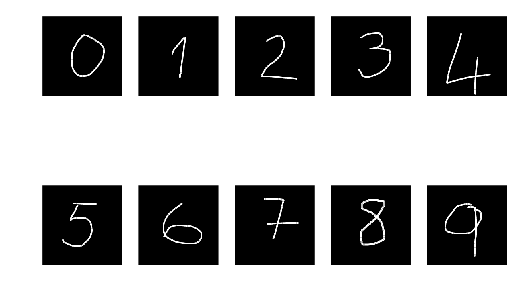

In [23]:
# Plot the example handwritten digits
for i, digit in enumerate(digits):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [24]:
digits = [prep.crop_img(digit) for digit in digits]

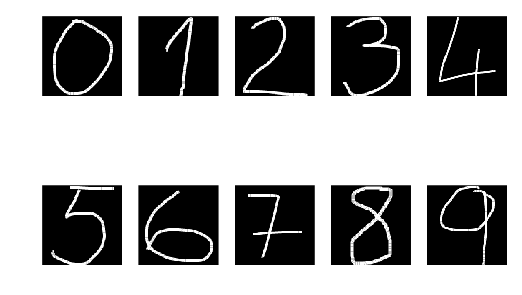

In [25]:
# Plot the cropped digits
for i, digit in enumerate(digits):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [26]:
digits = [prep.resize_img(digit) for digit in digits]

In [27]:
digits[0].shape

(28, 28)

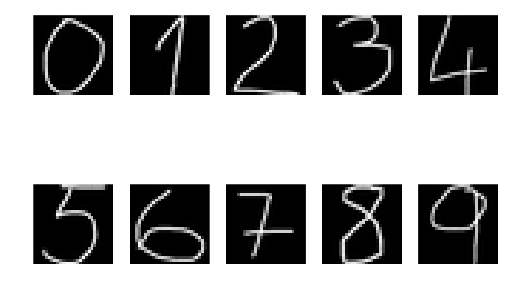

In [28]:
# Plot the cropped digits
for i, digit in enumerate(digits):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [29]:
#digits = [prep.flatten_img(digit) for digit in digits]
digits[4].shape

(28, 28)

In [55]:
# Load the tflearn pre-trained model
model = tflearn.DNN(cnn, tensorboard_verbose=0)
model.load('cnn.tflearn')

NotFoundError: Tensor name "Accuracy/Mean/moving_avg_1" not found in checkpoint files cnn.tflearn
	 [[Node: save_11/restore_slice_1 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_11/Const_0, save_11/restore_slice_1/tensor_name, save_11/restore_slice_1/shape_and_slice)]]

Caused by op 'save_11/restore_slice_1', defined at:
  File "/Users/luis/miniconda3/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/luis/miniconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-b540ac46ae93>", line 2, in <module>
    model = tflearn.DNN(cnn, tensorboard_verbose=0)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tflearn/models/dnn.py", line 57, in __init__
    session=session)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tflearn/helpers/trainer.py", line 125, in __init__
    keep_checkpoint_every_n_hours=keep_checkpoint_every_n_hours)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1077, in __init__
    self.build()
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1106, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 704, in build
    restore_sequentially, reshape)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 441, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 281, in restore_op
    preferred_shard=preferred_shard))
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/luis/miniconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "Accuracy/Mean/moving_avg_1" not found in checkpoint files cnn.tflearn
	 [[Node: save_11/restore_slice_1 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_11/Const_0, save_11/restore_slice_1/tensor_name, save_11/restore_slice_1/shape_and_slice)]]


In [46]:
pred = {key: np.around(model.predict(np.reshape(value, (1, 28, 28, 1), order='C')), 2) for (key, value) in enumerate(digits)}

AttributeError: 'NoneType' object has no attribute 'predict'

In [43]:
pred

{0: array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 1: array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]]),
 2: array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 3: array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 4: array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]]),
 5: array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]]),
 6: array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 7: array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 8: array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 9: array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])}

[Back to top](#Top)